# ABM COVID-19 model with Mesa

* https://github.com/projectmesa/mesa/wiki/Mesa-Packages
* https://github.com/metalcorebear/Mesa-SIR
* https://github.com/projectmesa/mesa/blob/master/examples/virus_on_network/virus_on_network/model.py
* https://github.com/Corvince/mesa-geo
* https://www.youtube.com/watch?v=lcySLoprPMc&t=202s
* https://www.sciencedirect.com/science/article/pii/S1755436517300221
* https://nbviewer.jupyter.org/gist/jlstevens/9c7835e4e21c5d844ded

In [1]:
import time, enum
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

In [166]:
# Bokeh libraries
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.palettes import brewer, Category10, Viridis
from bokeh.models.glyphs import Line
output_notebook()

import panel as pn
import panel.widgets as pnw
pn.extension()

Loading BokehJS ...

In [3]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2

## Define an agent class

In [4]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = self.random.normalvariate(20,40)        
        self.state = State.SUSCEPTIBLE  
        self.infection_time = 0

    def move(self):
        """Move the agent"""

        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""
        
        if self.state == State.INFECTED:     
            drate = self.model.death_rate
            alive = np.random.choice([0,1], p=[drate,1-drate])
            if alive == 0:
                self.model.schedule.remove(self)            
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.REMOVED
            #print (self.model.schedule.time,self.recovery_time,t)

    def contact(self):
        """Find close contacts and infect"""
        
        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            #other = self.random.choice(cellmates)
            for other in cellmates:
                #print (self.model.schedule.time,self.state,other.state)                
                if self.random.random() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = model.get_recovery_time()
                
    def step(self):
        self.status()
        self.move()
        self.contact()


## Model class

In [5]:
class InfectionModel(Model):
    """A model for infection spread."""
    
    def __init__(self, N=10, width=10, height=10, ptrans=0.5, 
                 progression_period=3, progression_sd=2, death_rate=0.0193, recovery_days=21,
                 recovery_sd=7):
        
        self.num_agents = N
        self.initial_outbreak_size = 1
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.death_rate = death_rate
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.dead_agents = []
        # Create agents
        for i in range(self.num_agents):
            a = MyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            #make some agents infected at start
            infected = np.random.choice([0,1], p=[0.98,0.02])
            if infected == 1:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()
            
        self.datacollector = DataCollector(
            #model_reporters={"Gini": compute_gini}, 
            agent_reporters={"State": "state"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


In [6]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Infected','Removed']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)

In [7]:
pop=300
steps=100
st=time.time()
model = InfectionModel(pop, 20, 20, ptrans=0.5)
for i in range(steps):
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model))

0.7240676879882812
      Susceptible  Infected  Removed
Step                                
0             293         7        0
1             292         8        0
2             291         9        0
3             287        13        0
4             282        18        0
5             277        22        0
6             266        33        0
7             256        41        0
8             246        49        1
9             239        55        1
10            224        70        1
11            205        87        2
12            185       105        2
13            171       118        2
14            149       138        3
15            128       153        5
16            104       173        7
17             98       177        7
18             84       182       11
19             69       187       17
20             58       190       21
21             53       190       26
22             42       188       32
23             33       187       36
24             28  

In [18]:
rscript = """
Infected <- c(2,3,3,3,4,5,5,5,6,6,6,6,6,6,6,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,14,18,38,57,100,130,191,204,285,377,653,949,1126,1209,1784,2281,2281,3661,4469,4499,6633,7652,9043,10871,12612,14282,16018,19856,22304,25233,29155,32964,37575,40174,44550,52128,56989,59105,64338,89953,92839,98010,109069,112950,117749,124869,129654,129654)

Day <- 1:(length(Infected)) # length of the infection period
N <- 66990000 # pupulation of the FR

old <- par(mfrow = c(1, 2)) # Plot coutnry's confirmed cases
plot(Day, Infected, type ="b")
plot(Day, Infected, log = "y") # type b by default
abline(lm(log10(Infected) ~ Day))
title("Confirmed COVID-19 cases in FR, lin & log scales", outer = TRUE, line = -2)

## Let's extrapolate to maybe 90 days, via epidemiologic modeling
SIR <- function(time, state, parameters) {
  par <- as.list(c(state, parameters))
  with(par, {
    dS <- -beta/N * I * S
    dI <- beta/N * I * S - gamma * I
    dR <- gamma * I
    list(c(dS, dI, dR))
  })
}

init <- c(S = N-Infected[1], I = Infected[1], R = 0)
RSS <- function(parameters) {
  names(parameters) <- c("beta", "gamma")
  out <- ode(y = init, times = Day, func = SIR, parms = parameters)
  fit <- out[ , 3]
  sum((Infected - fit)^2)
}

# general optimazion nethod
Opt <- optim(c(0.5, 0.5), RSS, method = "L-BFGS-B", lower = c(0, 0), upper = c(1, 1)) # optimize with some sensible conditions
Opt$message

Opt_par <- setNames(Opt$par, c("beta", "gamma"))
print(Opt_par)


## Either we use these params, OR let's choose, instead, the following values for gamma, beta and RO (based on studies)
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
# γ=0.2 corresponding here to an average length of the infective period of 5 days.
gamma <- 1/5 

# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma i.e
# a contact rate of β=0.00000004 means that the contact rate with a given individual is 0.0000004 contacts per day.
beta <- 4e-08 

# R0 for the beta and gamma values
# Altogether, this leads to an R0 of 2.25, which roughly corresponds to the R0 of SARS-CoV-2
R0 = 2.25
#R0 <- beta*N/gamma

# So Opt_par becomes
Opt_par["beta"] = 4e-08
Opt_par["gamma"] = 0.5

# Grid where to evaluate
max_time <- 150 # here predictions up to 150 days, i.e + (length(Day)-max_time) beyond length(Day)
times <- seq(0, max_time, by=0.01)

# time in days, prediction to up to 90 days (highly unlikely fact will confirm the hypothesis though)
#fit <- data.frame(ode(y = init, times = t, func = SIR, parms = Opt_par))
fit <- data.frame(ode(y = init, times = times, func = SIR, parms = Opt_par))
col <- 1:3 # colour
print(fit)


# Plot infection curve
matplot(fit$time, fit[ , 2:4], type = "l", xlab = "Day", ylab = "Number of subjects", lwd = 2, lty = 1, col = col)
matplot(fit$time, fit[ , 2:4], type = "l", xlab = "Day", ylab = "Number of subjects", lwd = 2, lty = 1, col = col, log = "y")
points(Day, Infected)
legend("bottomright", c("Susceptibles", "Infecteds", "Recovereds"), lty = 1, lwd = 1, col = col, inset = 0.05)
title("Predicted 2019-nCoV in FR (worst case), SIR", outer = TRUE, line = -2)


"""



In [64]:
# For SW
Infected = np.array([2,7,7,12,14,15,21,35,94,101,161,203,248,355,500,599,814,961,1022,1103,1190,1279,1439,1639,1763,1934,2046,2286,2526,2840,3069,3447,3700,4028,4435,4947,5568,6131,6443,6830,7206,7693,8419,9141,9685,10151,10483,10948,11445,11927,12540,13216,13822,14385,14777,15322,16004,16755,17567,18177,18640,18926,19621,20302,21092,21520,22082,22317,22721,23216,23918,24623,25265,25921,26322])
log_Infected = np.log(Infected)
    
# Use arange to quickly create a one-dimensional array or an array with a rank 1
## source: https://www.pluralsight.com/guides/different-ways-create-numpy-arrays
Day_i = np.arange(len(Infected)) # length of the infection period, different from the length of death cases period
Day_i


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74])

In [66]:
# For SW
Deaths = np.array([2,3,6,7,10,11,16,20,21,25,36,62,77,105,105,110,146,180,239,308,358,373,401,477,591,687,793,870,887,899,919,1033,1203,1333,1400,1511,1540,1580,1765,1937,2021,2152,2192,2194,2274,2355,2462,2586,2653,2669,2679,2769,2854,2941,3040,3175,3220,3225])
log_Deaths = np.log(Deaths)

Day_d = np.arange(len(Deaths))
Day_d

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57])

In [67]:
N = 10230000 # pupulation of the SW

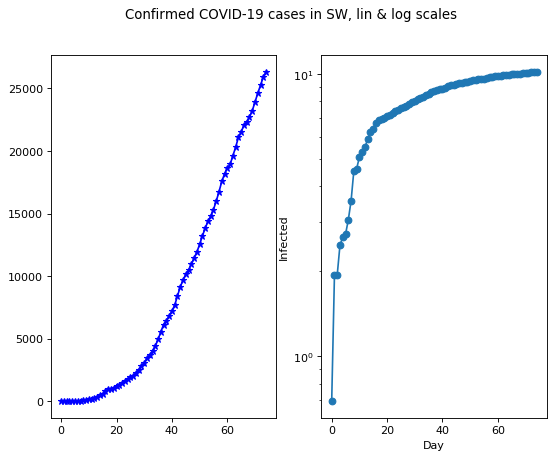

In [68]:
# from matplotlib import pyplot

x = Day_i
y = Infected
z = log_Infected

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,6), dpi=80) # 80-by-80 pixels image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,6), dpi=80) 
#fig, (ax1, ax2) = plt.subplots(2) 
fig.suptitle('Confirmed COVID-19 cases in SW, lin & log scales')

#ax1.plot(x, y), with ax1 = axs[0, 0]
ax1.plot(x, y, color = 'blue', marker = "*") 
ax2.plot(x, z, 'tab:blue', marker = "o")

# set chart titles
#ax1.set_title('Confirmed COVID-19 cases in SW') # axs[0, 0]
#ax2.set_title('Confirmed COVID-19 cases in SW, log scale')


# plotting the points  
#plt.plot(Day, Infected)
  
# naming the x axis 
plt.xlabel('Day') 
# naming the y axis 
plt.ylabel('Infected')

plt.yscale('log')

# Plot country's confirmed cases
#plt.title('Infected cases') 
  
# function to show the plot 
#plt.show()
plt.savefig('COVID-19_confirmed_cases_11052020.png',dpi=150) 


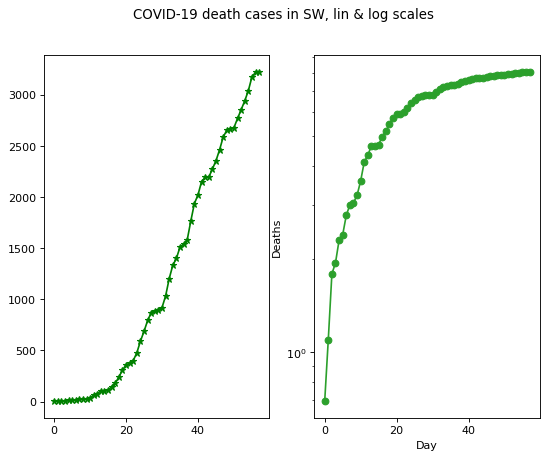

In [83]:
x = Day_d
y = Deaths
z = log_Deaths

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,6), dpi=80) 

fig.suptitle('COVID-19 death cases in SW, lin & log scales')

ax1.plot(x, y, color = 'green', marker = "*") # ax1
ax2.plot(x, z, 'tab:green', marker = "o") # ax2
  
# naming the x axis 
plt.xlabel('Day') 
# naming the y axis 
plt.ylabel('Deaths')

plt.yscale('log')
  
# Save plot 
#plt.show()
plt.savefig('COVID-19_death_cases_11052020.png',dpi=150)


In [25]:
!pip install rpy2
import rpy2.robjects as robjects

    100% |████████████████████████████████| 174kB 3.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for rpy2 ... done
  Stored in directory: /home/desire/.cache/pip/wheels/0c/32/85/0c93755ffd3874f100583bbf6c30f28a67d647f3dbc28e7f46
Successfully built rpy2


In [47]:
r = robjects.r
r.source('covid19_infected.R')

R[write to console]: trying URL 'https://stat.ethz.ch/CRAN/src/contrib/tidyverse_1.3.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 712837 bytes (696 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: 

R[write to console]: downloaded 1.3 MB


R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/tmp/Rtmpj2FqGy/downloaded_packages’
R[write to console]: 
R[write to console]: 

R[write to console]: Updating HTML index of packages in '.Library'

R[write to console]: Making 'packages.html' ...
R[write to console]:  done

R[write to console]: trying URL 'https://stat.ethz.ch/CRAN/src/contrib/magrittr_1.5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 200504 bytes (195 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to co

     beta     gamma 
0.5674834 0.4325200 
        time        S            I            R
1       0.00 10229998 2.000000e+00 0.000000e+00
2       0.01 10229998 2.002701e+00 8.656241e-03
3       0.02 10229998 2.005406e+00 1.732417e-02
4       0.03 10229998 2.008114e+00 2.600381e-02
5       0.04 10229998 2.010826e+00 3.469517e-02
6       0.05 10229998 2.013542e+00 4.339826e-02
7       0.06 10229998 2.016261e+00 5.211311e-02
8       0.07 10229998 2.018984e+00 6.083973e-02
9       0.08 10229998 2.021711e+00 6.957814e-02
10      0.09 10229998 2.024442e+00 7.832835e-02
11      0.10 10229998 2.027176e+00 8.709037e-02
12      0.11 10229998 2.029913e+00 9.586423e-02
13      0.12 10229998 2.032655e+00 1.046499e-01
14      0.13 10229998 2.035400e+00 1.134475e-01
15      0.14 10229998 2.038149e+00 1.222570e-01
16      0.15 10229998 2.040902e+00 1.310783e-01
17      0.16 10229998 2.043658e+00 1.399116e-01
18      0.17 10229998 2.046418e+00 1.487568e-01
19      0.18 10229998 2.049182e+00 1.576139e-0

169     1.68 10229996 2.509003e+00 1.631214e+00
170     1.69 10229996 2.512391e+00 1.642073e+00
171     1.70 10229996 2.515784e+00 1.652947e+00
172     1.71 10229996 2.519182e+00 1.663836e+00
173     1.72 10229996 2.522584e+00 1.674739e+00
174     1.73 10229996 2.525991e+00 1.685657e+00
175     1.74 10229996 2.529403e+00 1.696590e+00
176     1.75 10229996 2.532819e+00 1.707537e+00
177     1.76 10229996 2.536239e+00 1.718500e+00
178     1.77 10229996 2.539665e+00 1.729477e+00
179     1.78 10229996 2.543095e+00 1.740469e+00
180     1.79 10229996 2.546529e+00 1.751476e+00
181     1.80 10229996 2.549968e+00 1.762497e+00
182     1.81 10229996 2.553412e+00 1.773534e+00
183     1.82 10229996 2.556861e+00 1.784585e+00
184     1.83 10229996 2.560314e+00 1.795652e+00
185     1.84 10229996 2.563772e+00 1.806733e+00
186     1.85 10229996 2.567234e+00 1.817830e+00
187     1.86 10229996 2.570701e+00 1.828941e+00
188     1.87 10229996 2.574173e+00 1.840067e+00
189     1.88 10229996 2.577650e+00 1.851

339     3.38 10229993 3.156054e+00 3.704838e+00
340     3.39 10229993 3.160317e+00 3.718498e+00
341     3.40 10229993 3.164585e+00 3.732176e+00
342     3.41 10229993 3.168859e+00 3.745873e+00
343     3.42 10229993 3.173139e+00 3.759588e+00
344     3.43 10229993 3.177424e+00 3.773322e+00
345     3.44 10229993 3.181715e+00 3.787074e+00
346     3.45 10229993 3.186012e+00 3.800845e+00
347     3.46 10229993 3.190315e+00 3.814634e+00
348     3.47 10229993 3.194624e+00 3.828442e+00
349     3.48 10229993 3.198938e+00 3.842269e+00
350     3.49 10229993 3.203259e+00 3.856115e+00
351     3.50 10229993 3.207585e+00 3.869979e+00
352     3.51 10229993 3.211917e+00 3.883861e+00
353     3.52 10229993 3.216254e+00 3.897763e+00
354     3.53 10229993 3.220598e+00 3.911683e+00
355     3.54 10229993 3.224948e+00 3.925622e+00
356     3.55 10229993 3.229303e+00 3.939580e+00
357     3.56 10229993 3.233664e+00 3.953557e+00
358     3.57 10229993 3.238032e+00 3.967553e+00
359     3.58 10229993 3.242405e+00 3.981

509     5.08 10229990 3.969974e+00 6.313233e+00
510     5.09 10229990 3.975336e+00 6.330416e+00
511     5.10 10229990 3.980705e+00 6.347621e+00
512     5.11 10229990 3.986081e+00 6.364850e+00
513     5.12 10229990 3.991464e+00 6.382103e+00
514     5.13 10229990 3.996855e+00 6.399378e+00
515     5.14 10229990 4.002253e+00 6.416677e+00
516     5.15 10229990 4.007658e+00 6.433999e+00
517     5.16 10229990 4.013070e+00 6.451345e+00
518     5.17 10229990 4.018490e+00 6.468714e+00
519     5.18 10229989 4.023917e+00 6.486106e+00
520     5.19 10229989 4.029352e+00 6.503522e+00
521     5.20 10229989 4.034794e+00 6.520962e+00
522     5.21 10229989 4.040243e+00 6.538425e+00
523     5.22 10229989 4.045699e+00 6.555912e+00
524     5.23 10229989 4.051163e+00 6.573422e+00
525     5.24 10229989 4.056634e+00 6.590956e+00
526     5.25 10229989 4.062113e+00 6.608513e+00
527     5.26 10229989 4.067599e+00 6.626095e+00
528     5.27 10229989 4.073093e+00 6.643700e+00
529     5.28 10229989 4.078593e+00 6.661

679     6.78 10229985 4.993795e+00 9.594310e+00
680     6.79 10229985 5.000540e+00 9.615924e+00
681     6.80 10229985 5.007293e+00 9.637567e+00
682     6.81 10229985 5.014056e+00 9.659239e+00
683     6.82 10229985 5.020827e+00 9.680941e+00
684     6.83 10229985 5.027608e+00 9.702671e+00
685     6.84 10229985 5.034398e+00 9.724432e+00
686     6.85 10229985 5.041197e+00 9.746221e+00
687     6.86 10229985 5.048006e+00 9.768040e+00
688     6.87 10229985 5.054823e+00 9.789888e+00
689     6.88 10229985 5.061650e+00 9.811766e+00
690     6.89 10229985 5.068486e+00 9.833674e+00
691     6.90 10229985 5.075331e+00 9.855611e+00
692     6.91 10229985 5.082185e+00 9.877577e+00
693     6.92 10229985 5.089049e+00 9.899574e+00
694     6.93 10229985 5.095922e+00 9.921600e+00
695     6.94 10229985 5.102804e+00 9.943655e+00
696     6.95 10229985 5.109696e+00 9.965741e+00
697     6.96 10229985 5.116597e+00 9.987856e+00
698     6.97 10229985 5.123507e+00 1.001000e+01
699     6.98 10229985 5.130426e+00 1.003

849     8.48 10229980 6.281648e+00 1.372155e+01
850     8.49 10229980 6.290132e+00 1.374874e+01
851     8.50 10229980 6.298627e+00 1.377596e+01
852     8.51 10229980 6.307133e+00 1.380322e+01
853     8.52 10229980 6.315651e+00 1.383052e+01
854     8.53 10229980 6.324181e+00 1.385785e+01
855     8.54 10229980 6.332722e+00 1.388523e+01
856     8.55 10229980 6.341274e+00 1.391263e+01
857     8.56 10229980 6.349838e+00 1.394008e+01
858     8.57 10229980 6.358414e+00 1.396756e+01
859     8.58 10229980 6.367001e+00 1.399508e+01
860     8.59 10229980 6.375600e+00 1.402264e+01
861     8.60 10229980 6.384211e+00 1.405023e+01
862     8.61 10229980 6.392833e+00 1.407787e+01
863     8.62 10229979 6.401466e+00 1.410554e+01
864     8.63 10229979 6.410112e+00 1.413324e+01
865     8.64 10229979 6.418769e+00 1.416099e+01
866     8.65 10229979 6.427438e+00 1.418877e+01
867     8.66 10229979 6.436118e+00 1.421659e+01
868     8.67 10229979 6.444810e+00 1.424444e+01
869     8.68 10229979 6.453514e+00 1.427

1019   10.18 10229973 7.901621e+00 1.891316e+01
1020   10.19 10229973 7.912293e+00 1.894736e+01
1021   10.20 10229973 7.922978e+00 1.898160e+01
1022   10.21 10229973 7.933679e+00 1.901589e+01
1023   10.22 10229973 7.944393e+00 1.905023e+01
1024   10.23 10229973 7.955122e+00 1.908462e+01
1025   10.24 10229973 7.965866e+00 1.911905e+01
1026   10.25 10229973 7.976624e+00 1.915352e+01
1027   10.26 10229973 7.987397e+00 1.918805e+01
1028   10.27 10229973 7.998184e+00 1.922262e+01
1029   10.28 10229973 8.008986e+00 1.925724e+01
1030   10.29 10229973 8.019802e+00 1.929190e+01
1031   10.30 10229973 8.030633e+00 1.932661e+01
1032   10.31 10229973 8.041479e+00 1.936137e+01
1033   10.32 10229973 8.052339e+00 1.939617e+01
1034   10.33 10229973 8.063214e+00 1.943102e+01
1035   10.34 10229972 8.074104e+00 1.946592e+01
1036   10.35 10229972 8.085008e+00 1.950087e+01
1037   10.36 10229972 8.095927e+00 1.953586e+01
1038   10.37 10229972 8.106861e+00 1.957090e+01
1039   10.38 10229972 8.117809e+00 1.960

1189   11.88 10229965 9.939362e+00 2.544363e+01
1190   11.89 10229965 9.952785e+00 2.548665e+01
1191   11.90 10229965 9.966227e+00 2.552973e+01
1192   11.91 10229964 9.979686e+00 2.557286e+01
1193   11.92 10229964 9.993164e+00 2.561605e+01
1194   11.93 10229964 1.000666e+01 2.565931e+01
1195   11.94 10229964 1.002017e+01 2.570262e+01
1196   11.95 10229964 1.003371e+01 2.574598e+01
1197   11.96 10229964 1.004726e+01 2.578941e+01
1198   11.97 10229964 1.006083e+01 2.583290e+01
1199   11.98 10229964 1.007441e+01 2.587644e+01
1200   11.99 10229964 1.008802e+01 2.592005e+01
1201   12.00 10229964 1.010164e+01 2.596371e+01
1202   12.01 10229964 1.011529e+01 2.600743e+01
1203   12.02 10229964 1.012895e+01 2.605121e+01
1204   12.03 10229964 1.014263e+01 2.609505e+01
1205   12.04 10229964 1.015632e+01 2.613895e+01
1206   12.05 10229964 1.017004e+01 2.618290e+01
1207   12.06 10229964 1.018378e+01 2.622692e+01
1208   12.07 10229964 1.019753e+01 2.627100e+01
1209   12.08 10229963 1.021130e+01 2.631

1359   13.58 10229954 1.250260e+01 3.365824e+01
1360   13.59 10229954 1.251949e+01 3.371235e+01
1361   13.60 10229954 1.253639e+01 3.376653e+01
1362   13.61 10229954 1.255332e+01 3.382079e+01
1363   13.62 10229954 1.257028e+01 3.387513e+01
1364   13.63 10229953 1.258725e+01 3.392953e+01
1365   13.64 10229953 1.260425e+01 3.398401e+01
1366   13.65 10229953 1.262128e+01 3.403856e+01
1367   13.66 10229953 1.263832e+01 3.409319e+01
1368   13.67 10229953 1.265539e+01 3.414789e+01
1369   13.68 10229953 1.267248e+01 3.420266e+01
1370   13.69 10229953 1.268960e+01 3.425751e+01
1371   13.70 10229953 1.270673e+01 3.431243e+01
1372   13.71 10229953 1.272389e+01 3.436743e+01
1373   13.72 10229953 1.274108e+01 3.442250e+01
1374   13.73 10229953 1.275829e+01 3.447765e+01
1375   13.74 10229953 1.277552e+01 3.453287e+01
1376   13.75 10229953 1.279277e+01 3.458816e+01
1377   13.76 10229953 1.281005e+01 3.464353e+01
1378   13.77 10229952 1.282735e+01 3.469897e+01
1379   13.78 10229952 1.284467e+01 3.475

1529   15.28 10229940 1.572685e+01 4.399128e+01
1530   15.29 10229940 1.574809e+01 4.405935e+01
1531   15.30 10229940 1.576936e+01 4.412751e+01
1532   15.31 10229940 1.579066e+01 4.419576e+01
1533   15.32 10229940 1.581198e+01 4.426410e+01
1534   15.33 10229940 1.583334e+01 4.433254e+01
1535   15.34 10229940 1.585472e+01 4.440107e+01
1536   15.35 10229940 1.587613e+01 4.446969e+01
1537   15.36 10229940 1.589757e+01 4.453840e+01
1538   15.37 10229939 1.591904e+01 4.460721e+01
1539   15.38 10229939 1.594054e+01 4.467611e+01
1540   15.39 10229939 1.596207e+01 4.474510e+01
1541   15.40 10229939 1.598362e+01 4.481419e+01
1542   15.41 10229939 1.600521e+01 4.488337e+01
1543   15.42 10229939 1.602683e+01 4.495264e+01
1544   15.43 10229939 1.604847e+01 4.502201e+01
1545   15.44 10229939 1.607014e+01 4.509147e+01
1546   15.45 10229939 1.609185e+01 4.516102e+01
1547   15.46 10229939 1.611358e+01 4.523067e+01
1548   15.47 10229939 1.613534e+01 4.530041e+01
1549   15.48 10229938 1.615713e+01 4.537

1699   16.98 10229923 1.978256e+01 5.698907e+01
1700   16.99 10229923 1.980928e+01 5.707469e+01
1701   17.00 10229923 1.983603e+01 5.716043e+01
1702   17.01 10229923 1.986282e+01 5.724628e+01
1703   17.02 10229923 1.988965e+01 5.733225e+01
1704   17.03 10229923 1.991651e+01 5.741833e+01
1705   17.04 10229923 1.994340e+01 5.750453e+01
1706   17.05 10229922 1.997034e+01 5.759085e+01
1707   17.06 10229922 1.999731e+01 5.767729e+01
1708   17.07 10229922 2.002431e+01 5.776384e+01
1709   17.08 10229922 2.005136e+01 5.785050e+01
1710   17.09 10229922 2.007844e+01 5.793729e+01
1711   17.10 10229922 2.010555e+01 5.802419e+01
1712   17.11 10229922 2.013270e+01 5.811121e+01
1713   17.12 10229922 2.015989e+01 5.819835e+01
1714   17.13 10229922 2.018712e+01 5.828560e+01
1715   17.14 10229921 2.021438e+01 5.837297e+01
1716   17.15 10229921 2.024168e+01 5.846046e+01
1717   17.16 10229921 2.026902e+01 5.854807e+01
1718   17.17 10229921 2.029639e+01 5.863580e+01
1719   17.18 10229921 2.032380e+01 5.872

1869   18.68 10229902 2.488414e+01 7.333877e+01
1870   18.69 10229902 2.491774e+01 7.344647e+01
1871   18.70 10229901 2.495139e+01 7.355432e+01
1872   18.71 10229901 2.498509e+01 7.366231e+01
1873   18.72 10229901 2.501883e+01 7.377045e+01
1874   18.73 10229901 2.505262e+01 7.387873e+01
1875   18.74 10229901 2.508645e+01 7.398716e+01
1876   18.75 10229901 2.512033e+01 7.409574e+01
1877   18.76 10229901 2.515426e+01 7.420446e+01
1878   18.77 10229900 2.518823e+01 7.431334e+01
1879   18.78 10229900 2.522224e+01 7.442235e+01
1880   18.79 10229900 2.525631e+01 7.453152e+01
1881   18.80 10229900 2.529041e+01 7.464083e+01
1882   18.81 10229900 2.532457e+01 7.475029e+01
1883   18.82 10229900 2.535877e+01 7.485990e+01
1884   18.83 10229900 2.539302e+01 7.496965e+01
1885   18.84 10229899 2.542731e+01 7.507956e+01
1886   18.85 10229899 2.546165e+01 7.518961e+01
1887   18.86 10229899 2.549603e+01 7.529981e+01
1888   18.87 10229899 2.553047e+01 7.541016e+01
1889   18.88 10229899 2.556494e+01 7.552

2039   20.38 10229875 3.130124e+01 9.390474e+01
2040   20.39 10229875 3.134351e+01 9.404022e+01
2041   20.40 10229874 3.138584e+01 9.417588e+01
2042   20.41 10229874 3.142823e+01 9.431172e+01
2043   20.42 10229874 3.147067e+01 9.444774e+01
2044   20.43 10229874 3.151317e+01 9.458395e+01
2045   20.44 10229874 3.155573e+01 9.472035e+01
2046   20.45 10229874 3.159834e+01 9.485692e+01
2047   20.46 10229873 3.164102e+01 9.499368e+01
2048   20.47 10229873 3.168375e+01 9.513063e+01
2049   20.48 10229873 3.172653e+01 9.526776e+01
2050   20.49 10229873 3.176938e+01 9.540508e+01
2051   20.50 10229873 3.181228e+01 9.554258e+01
2052   20.51 10229872 3.185525e+01 9.568027e+01
2053   20.52 10229872 3.189827e+01 9.581814e+01
2054   20.53 10229872 3.194134e+01 9.595620e+01
2055   20.54 10229872 3.198448e+01 9.609445e+01
2056   20.55 10229872 3.202767e+01 9.623288e+01
2057   20.56 10229872 3.207093e+01 9.637150e+01
2058   20.57 10229871 3.211424e+01 9.651031e+01
2059   20.58 10229871 3.215761e+01 9.664

2209   22.08 10229841 3.937307e+01 1.197742e+02
2210   22.09 10229841 3.942625e+01 1.199446e+02
2211   22.10 10229840 3.947949e+01 1.201153e+02
2212   22.11 10229840 3.953280e+01 1.202861e+02
2213   22.12 10229840 3.958619e+01 1.204573e+02
2214   22.13 10229840 3.963965e+01 1.206286e+02
2215   22.14 10229840 3.969318e+01 1.208001e+02
2216   22.15 10229839 3.974679e+01 1.209719e+02
2217   22.16 10229839 3.980046e+01 1.211440e+02
2218   22.17 10229839 3.985421e+01 1.213162e+02
2219   22.18 10229839 3.990803e+01 1.214887e+02
2220   22.19 10229838 3.996193e+01 1.216615e+02
2221   22.20 10229838 4.001589e+01 1.218344e+02
2222   22.21 10229838 4.006993e+01 1.220076e+02
2223   22.22 10229838 4.012405e+01 1.221810e+02
2224   22.23 10229837 4.017823e+01 1.223547e+02
2225   22.24 10229837 4.023249e+01 1.225286e+02
2226   22.25 10229837 4.028682e+01 1.227027e+02
2227   22.26 10229837 4.034123e+01 1.228771e+02
2228   22.27 10229837 4.039571e+01 1.230517e+02
2229   22.28 10229836 4.045026e+01 1.232

2379   23.78 10229798 4.952626e+01 1.523148e+02
2380   23.79 10229798 4.959314e+01 1.525291e+02
2381   23.80 10229798 4.966011e+01 1.527438e+02
2382   23.81 10229797 4.972717e+01 1.529587e+02
2383   23.82 10229797 4.979433e+01 1.531739e+02
2384   23.83 10229797 4.986157e+01 1.533894e+02
2385   23.84 10229796 4.992891e+01 1.536052e+02
2386   23.85 10229796 4.999633e+01 1.538213e+02
2387   23.86 10229796 5.006385e+01 1.540377e+02
2388   23.87 10229796 5.013146e+01 1.542544e+02
2389   23.88 10229795 5.019916e+01 1.544714e+02
2390   23.89 10229795 5.026695e+01 1.546887e+02
2391   23.90 10229795 5.033483e+01 1.549062e+02
2392   23.91 10229794 5.040280e+01 1.551241e+02
2393   23.92 10229794 5.047087e+01 1.553422e+02
2394   23.93 10229794 5.053902e+01 1.555607e+02
2395   23.94 10229794 5.060727e+01 1.557794e+02
2396   23.95 10229793 5.067562e+01 1.559984e+02
2397   23.96 10229793 5.074405e+01 1.562178e+02
2398   23.97 10229793 5.081258e+01 1.564374e+02
2399   23.98 10229792 5.088120e+01 1.566

2549   25.48 10229744 6.229738e+01 1.932465e+02
2550   25.49 10229744 6.238150e+01 1.935161e+02
2551   25.50 10229744 6.246574e+01 1.937861e+02
2552   25.51 10229743 6.255010e+01 1.940564e+02
2553   25.52 10229743 6.263456e+01 1.943272e+02
2554   25.53 10229743 6.271915e+01 1.945983e+02
2555   25.54 10229742 6.280384e+01 1.948697e+02
2556   25.55 10229742 6.288865e+01 1.951415e+02
2557   25.56 10229742 6.297358e+01 1.954137e+02
2558   25.57 10229741 6.305862e+01 1.956863e+02
2559   25.58 10229741 6.314377e+01 1.959592e+02
2560   25.59 10229741 6.322904e+01 1.962325e+02
2561   25.60 10229740 6.331443e+01 1.965062e+02
2562   25.61 10229740 6.339993e+01 1.967802e+02
2563   25.62 10229739 6.348554e+01 1.970546e+02
2564   25.63 10229739 6.357127e+01 1.973294e+02
2565   25.64 10229739 6.365712e+01 1.976045e+02
2566   25.65 10229738 6.374308e+01 1.978800e+02
2567   25.66 10229738 6.382916e+01 1.981559e+02
2568   25.67 10229738 6.391535e+01 1.984322e+02
2569   25.68 10229737 6.400167e+01 1.987

2719   27.18 10229677 7.836128e+01 2.447329e+02
2720   27.19 10229676 7.846709e+01 2.450721e+02
2721   27.20 10229676 7.857305e+01 2.454117e+02
2722   27.21 10229676 7.867916e+01 2.457518e+02
2723   27.22 10229675 7.878540e+01 2.460923e+02
2724   27.23 10229675 7.889179e+01 2.464333e+02
2725   27.24 10229674 7.899832e+01 2.467747e+02
2726   27.25 10229674 7.910500e+01 2.471166e+02
2727   27.26 10229673 7.921182e+01 2.474590e+02
2728   27.27 10229673 7.931879e+01 2.478019e+02
2729   27.28 10229672 7.942589e+01 2.481452e+02
2730   27.29 10229672 7.953315e+01 2.484889e+02
2731   27.30 10229672 7.964055e+01 2.488332e+02
2732   27.31 10229671 7.974809e+01 2.491778e+02
2733   27.32 10229671 7.985578e+01 2.495230e+02
2734   27.33 10229670 7.996361e+01 2.498686e+02
2735   27.34 10229670 8.007159e+01 2.502147e+02
2736   27.35 10229669 8.017972e+01 2.505613e+02
2737   27.36 10229669 8.028799e+01 2.509083e+02
2738   27.37 10229668 8.039641e+01 2.512558e+02
2739   27.38 10229668 8.050497e+01 2.516

2889   28.88 10229592 9.856669e+01 3.094953e+02
2890   28.89 10229591 9.869978e+01 3.099219e+02
2891   28.90 10229591 9.883306e+01 3.103491e+02
2892   28.91 10229590 9.896652e+01 3.107769e+02
2893   28.92 10229590 9.910015e+01 3.112052e+02
2894   28.93 10229589 9.923397e+01 3.116341e+02
2895   28.94 10229589 9.936797e+01 3.120636e+02
2896   28.95 10229588 9.950214e+01 3.124937e+02
2897   28.96 10229587 9.963650e+01 3.129244e+02
2898   28.97 10229587 9.977104e+01 3.133556e+02
2899   28.98 10229586 9.990577e+01 3.137874e+02
2900   28.99 10229586 1.000407e+02 3.142198e+02
2901   29.00 10229585 1.001758e+02 3.146528e+02
2902   29.01 10229585 1.003110e+02 3.150864e+02
2903   29.02 10229584 1.004465e+02 3.155206e+02
2904   29.03 10229583 1.005821e+02 3.159553e+02
2905   29.04 10229583 1.007179e+02 3.163906e+02
2906   29.05 10229582 1.008539e+02 3.168265e+02
2907   29.06 10229582 1.009901e+02 3.172631e+02
2908   29.07 10229581 1.011265e+02 3.177002e+02
2909   29.08 10229581 1.012630e+02 3.181

3059   30.58 10229485 1.239809e+02 3.909563e+02
3060   30.59 10229484 1.241483e+02 3.914929e+02
3061   30.60 10229484 1.243160e+02 3.920303e+02
3062   30.61 10229483 1.244838e+02 3.925683e+02
3063   30.62 10229482 1.246519e+02 3.931071e+02
3064   30.63 10229482 1.248202e+02 3.936466e+02
3065   30.64 10229481 1.249888e+02 3.941869e+02
3066   30.65 10229480 1.251575e+02 3.947278e+02
3067   30.66 10229479 1.253265e+02 3.952695e+02
3068   30.67 10229479 1.254958e+02 3.958119e+02
3069   30.68 10229478 1.256652e+02 3.963551e+02
3070   30.69 10229477 1.258349e+02 3.968990e+02
3071   30.70 10229477 1.260048e+02 3.974436e+02
3072   30.71 10229476 1.261749e+02 3.979890e+02
3073   30.72 10229475 1.263453e+02 3.985351e+02
3074   30.73 10229474 1.265159e+02 3.990819e+02
3075   30.74 10229474 1.266867e+02 3.996295e+02
3076   30.75 10229473 1.268578e+02 4.001778e+02
3077   30.76 10229472 1.270291e+02 4.007269e+02
3078   30.77 10229472 1.272006e+02 4.012767e+02
3079   30.78 10229471 1.273723e+02 4.018

3229   32.28 10229351 1.559462e+02 4.934205e+02
3230   32.29 10229350 1.561567e+02 4.940955e+02
3231   32.30 10229349 1.563676e+02 4.947713e+02
3232   32.31 10229348 1.565787e+02 4.954481e+02
3233   32.32 10229347 1.567901e+02 4.961258e+02
3234   32.33 10229346 1.570018e+02 4.968044e+02
3235   32.34 10229345 1.572138e+02 4.974839e+02
3236   32.35 10229344 1.574260e+02 4.981644e+02
3237   32.36 10229344 1.576386e+02 4.988457e+02
3238   32.37 10229343 1.578514e+02 4.995280e+02
3239   32.38 10229342 1.580646e+02 5.002112e+02
3240   32.39 10229341 1.582780e+02 5.008953e+02
3241   32.40 10229340 1.584917e+02 5.015804e+02
3242   32.41 10229339 1.587057e+02 5.022663e+02
3243   32.42 10229338 1.589200e+02 5.029532e+02
3244   32.43 10229337 1.591345e+02 5.036411e+02
3245   32.44 10229336 1.593494e+02 5.043298e+02
3246   32.45 10229335 1.595645e+02 5.050195e+02
3247   32.46 10229335 1.597800e+02 5.057101e+02
3248   32.47 10229334 1.599957e+02 5.064017e+02
3249   32.48 10229333 1.602117e+02 5.070

3399   33.98 10229182 1.961500e+02 6.223015e+02
3400   33.99 10229180 1.964148e+02 6.231504e+02
3401   34.00 10229179 1.966800e+02 6.240005e+02
3402   34.01 10229178 1.969456e+02 6.248518e+02
3403   34.02 10229177 1.972114e+02 6.257042e+02
3404   34.03 10229176 1.974777e+02 6.265578e+02
3405   34.04 10229175 1.977443e+02 6.274125e+02
3406   34.05 10229174 1.980113e+02 6.282683e+02
3407   34.06 10229173 1.982786e+02 6.291253e+02
3408   34.07 10229171 1.985463e+02 6.299835e+02
3409   34.08 10229170 1.988144e+02 6.308429e+02
3410   34.09 10229169 1.990828e+02 6.317033e+02
3411   34.10 10229168 1.993516e+02 6.325650e+02
3412   34.11 10229167 1.996207e+02 6.334278e+02
3413   34.12 10229166 1.998902e+02 6.342918e+02
3414   34.13 10229165 2.001601e+02 6.351569e+02
3415   34.14 10229164 2.004303e+02 6.360233e+02
3416   34.15 10229162 2.007009e+02 6.368907e+02
3417   34.16 10229161 2.009719e+02 6.377594e+02
3418   34.17 10229160 2.012432e+02 6.386292e+02
3419   34.18 10229159 2.015149e+02 6.395

3569   35.68 10228969 2.467142e+02 7.844073e+02
3570   35.69 10228967 2.470473e+02 7.854751e+02
3571   35.70 10228966 2.473808e+02 7.865443e+02
3572   35.71 10228965 2.477148e+02 7.876150e+02
3573   35.72 10228963 2.480492e+02 7.886872e+02
3574   35.73 10228962 2.483840e+02 7.897607e+02
3575   35.74 10228960 2.487193e+02 7.908358e+02
3576   35.75 10228959 2.490551e+02 7.919123e+02
3577   35.76 10228958 2.493913e+02 7.929902e+02
3578   35.77 10228956 2.497280e+02 7.940696e+02
3579   35.78 10228955 2.500651e+02 7.951505e+02
3580   35.79 10228953 2.504027e+02 7.962328e+02
3581   35.80 10228952 2.507407e+02 7.973165e+02
3582   35.81 10228951 2.510792e+02 7.984018e+02
3583   35.82 10228949 2.514182e+02 7.994885e+02
3584   35.83 10228948 2.517576e+02 8.005766e+02
3585   35.84 10228946 2.520974e+02 8.016663e+02
3586   35.85 10228945 2.524377e+02 8.027574e+02
3587   35.86 10228943 2.527785e+02 8.038500e+02
3588   35.87 10228942 2.531198e+02 8.049440e+02
3589   35.88 10228940 2.534615e+02 8.060

3739   37.38 10228701 3.103061e+02 9.882989e+02
3740   37.39 10228700 3.107249e+02 9.896420e+02
3741   37.40 10228698 3.111443e+02 9.909868e+02
3742   37.41 10228696 3.115643e+02 9.923335e+02
3743   37.42 10228694 3.119849e+02 9.936820e+02
3744   37.43 10228693 3.124060e+02 9.950323e+02
3745   37.44 10228691 3.128277e+02 9.963844e+02
3746   37.45 10228689 3.132500e+02 9.977384e+02
3747   37.46 10228687 3.136728e+02 9.990942e+02
3748   37.47 10228685 3.140962e+02 1.000452e+03
3749   37.48 10228684 3.145202e+02 1.001811e+03
3750   37.49 10228682 3.149447e+02 1.003173e+03
3751   37.50 10228680 3.153698e+02 1.004536e+03
3752   37.51 10228678 3.157955e+02 1.005901e+03
3753   37.52 10228677 3.162218e+02 1.007267e+03
3754   37.53 10228675 3.166486e+02 1.008636e+03
3755   37.54 10228673 3.170760e+02 1.010007e+03
3756   37.55 10228671 3.175040e+02 1.011379e+03
3757   37.56 10228669 3.179326e+02 1.012753e+03
3758   37.57 10228668 3.183617e+02 1.014129e+03
3759   37.58 10228666 3.187915e+02 1.015

3909   39.08 10228365 3.902779e+02 1.244741e+03
3910   39.09 10228363 3.908047e+02 1.246430e+03
3911   39.10 10228361 3.913321e+02 1.248122e+03
3912   39.11 10228358 3.918603e+02 1.249815e+03
3913   39.12 10228356 3.923891e+02 1.251511e+03
3914   39.13 10228354 3.929187e+02 1.253210e+03
3915   39.14 10228352 3.934490e+02 1.254910e+03
3916   39.15 10228349 3.939800e+02 1.256613e+03
3917   39.16 10228347 3.945118e+02 1.258318e+03
3918   39.17 10228345 3.950442e+02 1.260026e+03
3919   39.18 10228343 3.955774e+02 1.261736e+03
3920   39.19 10228340 3.961112e+02 1.263448e+03
3921   39.20 10228338 3.966458e+02 1.265162e+03
3922   39.21 10228336 3.971812e+02 1.266879e+03
3923   39.22 10228334 3.977172e+02 1.268598e+03
3924   39.23 10228331 3.982540e+02 1.270319e+03
3925   39.24 10228329 3.987915e+02 1.272043e+03
3926   39.25 10228327 3.993297e+02 1.273769e+03
3927   39.26 10228325 3.998686e+02 1.275497e+03
3928   39.27 10228322 4.004083e+02 1.277228e+03
3929   39.28 10228320 4.009487e+02 1.278

4079   40.78 10227942 4.908426e+02 1.567268e+03
4080   40.79 10227939 4.915050e+02 1.569392e+03
4081   40.80 10227936 4.921682e+02 1.571519e+03
4082   40.81 10227934 4.928323e+02 1.573649e+03
4083   40.82 10227931 4.934974e+02 1.575782e+03
4084   40.83 10227928 4.941633e+02 1.577918e+03
4085   40.84 10227925 4.948301e+02 1.580057e+03
4086   40.85 10227922 4.954978e+02 1.582199e+03
4087   40.86 10227919 4.961664e+02 1.584343e+03
4088   40.87 10227917 4.968360e+02 1.586491e+03
4089   40.88 10227914 4.975064e+02 1.588641e+03
4090   40.89 10227911 4.981777e+02 1.590795e+03
4091   40.90 10227908 4.988500e+02 1.592951e+03
4092   40.91 10227905 4.995231e+02 1.595110e+03
4093   40.92 10227903 5.001971e+02 1.597272e+03
4094   40.93 10227900 5.008721e+02 1.599437e+03
4095   40.94 10227897 5.015480e+02 1.601605e+03
4096   40.95 10227894 5.022247e+02 1.603775e+03
4097   40.96 10227891 5.029024e+02 1.605949e+03
4098   40.97 10227888 5.035810e+02 1.608126e+03
4099   40.98 10227885 5.042605e+02 1.610

4249   42.48 10227410 6.172926e+02 1.972892e+03
4250   42.49 10227406 6.181254e+02 1.975564e+03
4251   42.50 10227403 6.189593e+02 1.978239e+03
4252   42.51 10227399 6.197943e+02 1.980918e+03
4253   42.52 10227396 6.206305e+02 1.983600e+03
4254   42.53 10227392 6.214678e+02 1.986286e+03
4255   42.54 10227389 6.223062e+02 1.988976e+03
4256   42.55 10227385 6.231457e+02 1.991670e+03
4257   42.56 10227382 6.239864e+02 1.994367e+03
4258   42.57 10227378 6.248282e+02 1.997067e+03
4259   42.58 10227375 6.256712e+02 1.999772e+03
4260   42.59 10227371 6.265153e+02 2.002480e+03
4261   42.60 10227367 6.273605e+02 2.005191e+03
4262   42.61 10227364 6.282069e+02 2.007907e+03
4263   42.62 10227360 6.290544e+02 2.010626e+03
4264   42.63 10227357 6.299030e+02 2.013348e+03
4265   42.64 10227353 6.307528e+02 2.016074e+03
4266   42.65 10227350 6.316037e+02 2.018804e+03
4267   42.66 10227346 6.324558e+02 2.021538e+03
4268   42.67 10227342 6.333090e+02 2.024275e+03
4269   42.68 10227339 6.341634e+02 2.027

4419   44.18 10226741 7.762746e+02 2.482998e+03
4420   44.19 10226736 7.773215e+02 2.486358e+03
4421   44.20 10226732 7.783699e+02 2.489722e+03
4422   44.21 10226727 7.794198e+02 2.493091e+03
4423   44.22 10226723 7.804710e+02 2.496464e+03
4424   44.23 10226719 7.815236e+02 2.499842e+03
4425   44.24 10226714 7.825777e+02 2.503225e+03
4426   44.25 10226710 7.836332e+02 2.506612e+03
4427   44.26 10226705 7.846900e+02 2.510003e+03
4428   44.27 10226701 7.857484e+02 2.513400e+03
4429   44.28 10226696 7.868081e+02 2.516801e+03
4430   44.29 10226692 7.878693e+02 2.520206e+03
4431   44.30 10226687 7.889319e+02 2.523616e+03
4432   44.31 10226683 7.899959e+02 2.527031e+03
4433   44.32 10226678 7.910614e+02 2.530450e+03
4434   44.33 10226674 7.921283e+02 2.533874e+03
4435   44.34 10226670 7.931966e+02 2.537302e+03
4436   44.35 10226665 7.942664e+02 2.540735e+03
4437   44.36 10226660 7.953376e+02 2.544173e+03
4438   44.37 10226656 7.964103e+02 2.547615e+03
4439   44.38 10226651 7.974844e+02 2.551

4589   45.88 10225899 9.761327e+02 3.124457e+03
4590   45.89 10225894 9.774488e+02 3.128682e+03
4591   45.90 10225888 9.787666e+02 3.132913e+03
4592   45.91 10225883 9.800863e+02 3.137149e+03
4593   45.92 10225877 9.814077e+02 3.141391e+03
4594   45.93 10225872 9.827309e+02 3.145639e+03
4595   45.94 10225866 9.840558e+02 3.149892e+03
4596   45.95 10225860 9.853826e+02 3.154151e+03
4597   45.96 10225855 9.867111e+02 3.158416e+03
4598   45.97 10225849 9.880414e+02 3.162687e+03
4599   45.98 10225844 9.893735e+02 3.166963e+03
4600   45.99 10225838 9.907075e+02 3.171245e+03
4601   46.00 10225832 9.920432e+02 3.175533e+03
4602   46.01 10225827 9.933807e+02 3.179827e+03
4603   46.02 10225821 9.947200e+02 3.184126e+03
4604   46.03 10225816 9.960611e+02 3.188431e+03
4605   46.04 10225810 9.974040e+02 3.192742e+03
4606   46.05 10225804 9.987487e+02 3.197059e+03
4607   46.06 10225799 1.000095e+03 3.201382e+03
4608   46.07 10225793 1.001444e+03 3.205710e+03
4609   46.08 10225787 1.002794e+03 3.210

4759   47.58 10224842 1.227336e+03 3.931030e+03
4760   47.59 10224835 1.228991e+03 3.936342e+03
4761   47.60 10224828 1.230647e+03 3.941661e+03
4762   47.61 10224821 1.232305e+03 3.946988e+03
4763   47.62 10224814 1.233966e+03 3.952321e+03
4764   47.63 10224807 1.235629e+03 3.957662e+03
4765   47.64 10224800 1.237294e+03 3.963010e+03
4766   47.65 10224793 1.238962e+03 3.968365e+03
4767   47.66 10224786 1.240631e+03 3.973728e+03
4768   47.67 10224779 1.242303e+03 3.979097e+03
4769   47.68 10224772 1.243977e+03 3.984474e+03
4770   47.69 10224764 1.245654e+03 3.989858e+03
4771   47.70 10224757 1.247333e+03 3.995249e+03
4772   47.71 10224750 1.249014e+03 4.000648e+03
4773   47.72 10224743 1.250697e+03 4.006054e+03
4774   47.73 10224736 1.252382e+03 4.011467e+03
4775   47.74 10224729 1.254070e+03 4.016887e+03
4776   47.75 10224722 1.255760e+03 4.022315e+03
4777   47.76 10224715 1.257452e+03 4.027750e+03
4778   47.77 10224708 1.259147e+03 4.033193e+03
4779   47.78 10224701 1.260844e+03 4.038

4929   49.28 10223512 1.543014e+03 4.945114e+03
4930   49.29 10223503 1.545092e+03 4.951792e+03
4931   49.30 10223494 1.547173e+03 4.958480e+03
4932   49.31 10223486 1.549257e+03 4.965176e+03
4933   49.32 10223477 1.551344e+03 4.971881e+03
4934   49.33 10223468 1.553433e+03 4.978596e+03
4935   49.34 10223459 1.555526e+03 4.985319e+03
4936   49.35 10223450 1.557621e+03 4.992052e+03
4937   49.36 10223441 1.559719e+03 4.998793e+03
4938   49.37 10223433 1.561819e+03 5.005544e+03
4939   49.38 10223424 1.563923e+03 5.012304e+03
4940   49.39 10223415 1.566029e+03 5.019073e+03
4941   49.40 10223406 1.568139e+03 5.025851e+03
4942   49.41 10223397 1.570251e+03 5.032638e+03
4943   49.42 10223388 1.572366e+03 5.039434e+03
4944   49.43 10223379 1.574484e+03 5.046239e+03
4945   49.44 10223370 1.576604e+03 5.053054e+03
4946   49.45 10223361 1.578728e+03 5.059877e+03
4947   49.46 10223352 1.580854e+03 5.066710e+03
4948   49.47 10223343 1.582983e+03 5.073552e+03
4949   49.48 10223334 1.585115e+03 5.080

5099   50.98 10221840 1.939611e+03 6.219936e+03
5100   50.99 10221829 1.942222e+03 6.228331e+03
5101   51.00 10221818 1.944836e+03 6.236737e+03
5102   51.01 10221807 1.947454e+03 6.245154e+03
5103   51.02 10221796 1.950075e+03 6.253583e+03
5104   51.03 10221785 1.952700e+03 6.262023e+03
5105   51.04 10221774 1.955328e+03 6.270475e+03
5106   51.05 10221763 1.957960e+03 6.278938e+03
5107   51.06 10221752 1.960595e+03 6.287412e+03
5108   51.07 10221741 1.963234e+03 6.295897e+03
5109   51.08 10221730 1.965877e+03 6.304395e+03
5110   51.09 10221719 1.968523e+03 6.312903e+03
5111   51.10 10221707 1.971172e+03 6.321423e+03
5112   51.11 10221696 1.973825e+03 6.329955e+03
5113   51.12 10221685 1.976482e+03 6.338497e+03
5114   51.13 10221674 1.979142e+03 6.347052e+03
5115   51.14 10221663 1.981806e+03 6.355618e+03
5116   51.15 10221651 1.984473e+03 6.364195e+03
5117   51.16 10221640 1.987144e+03 6.372784e+03
5118   51.17 10221629 1.989818e+03 6.381385e+03
5119   51.18 10221618 1.992496e+03 6.389

5269   52.68 10219740 2.437713e+03 7.822280e+03
5270   52.69 10219726 2.440992e+03 7.832831e+03
5271   52.70 10219712 2.444274e+03 7.843396e+03
5272   52.71 10219698 2.447562e+03 7.853975e+03
5273   52.72 10219685 2.450853e+03 7.864568e+03
5274   52.73 10219671 2.454149e+03 7.875176e+03
5275   52.74 10219657 2.457449e+03 7.885798e+03
5276   52.75 10219643 2.460754e+03 7.896434e+03
5277   52.76 10219629 2.464063e+03 7.907084e+03
5278   52.77 10219615 2.467377e+03 7.917749e+03
5279   52.78 10219601 2.470695e+03 7.928428e+03
5280   52.79 10219587 2.474018e+03 7.939121e+03
5281   52.80 10219573 2.477345e+03 7.949829e+03
5282   52.81 10219559 2.480676e+03 7.960551e+03
5283   52.82 10219545 2.484012e+03 7.971288e+03
5284   52.83 10219531 2.487352e+03 7.982039e+03
5285   52.84 10219516 2.490697e+03 7.992805e+03
5286   52.85 10219502 2.494046e+03 8.003585e+03
5287   52.86 10219488 2.497400e+03 8.014379e+03
5288   52.87 10219474 2.500758e+03 8.025188e+03
5289   52.88 10219460 2.504121e+03 8.036

5439   54.38 10217101 3.063050e+03 9.835891e+03
5440   54.39 10217084 3.067164e+03 9.849148e+03
5441   54.40 10217066 3.071285e+03 9.862423e+03
5442   54.41 10217049 3.075410e+03 9.875716e+03
5443   54.42 10217031 3.079542e+03 9.889027e+03
5444   54.43 10217014 3.083679e+03 9.902356e+03
5445   54.44 10216996 3.087821e+03 9.915702e+03
5446   54.45 10216979 3.091969e+03 9.929066e+03
5447   54.46 10216961 3.096122e+03 9.942449e+03
5448   54.47 10216944 3.100281e+03 9.955849e+03
5449   54.48 10216926 3.104446e+03 9.969268e+03
5450   54.49 10216909 3.108616e+03 9.982704e+03
5451   54.50 10216891 3.112792e+03 9.996158e+03
5452   54.51 10216873 3.116973e+03 1.000963e+04
5453   54.52 10216856 3.121160e+03 1.002312e+04
5454   54.53 10216838 3.125353e+03 1.003663e+04
5455   54.54 10216820 3.129551e+03 1.005016e+04
5456   54.55 10216803 3.133754e+03 1.006370e+04
5457   54.56 10216785 3.137964e+03 1.007727e+04
5458   54.57 10216767 3.142178e+03 1.009085e+04
5459   54.58 10216749 3.146399e+03 1.010

5609   56.08 10213787 3.847725e+03 1.236569e+04
5610   56.09 10213765 3.852887e+03 1.238234e+04
5611   56.10 10213743 3.858055e+03 1.239902e+04
5612   56.11 10213721 3.863231e+03 1.241572e+04
5613   56.12 10213699 3.868413e+03 1.243244e+04
5614   56.13 10213677 3.873603e+03 1.244918e+04
5615   56.14 10213655 3.878799e+03 1.246595e+04
5616   56.15 10213633 3.884002e+03 1.248274e+04
5617   56.16 10213611 3.889213e+03 1.249955e+04
5618   56.17 10213589 3.894430e+03 1.251638e+04
5619   56.18 10213567 3.899654e+03 1.253323e+04
5620   56.19 10213545 3.904885e+03 1.255011e+04
5621   56.20 10213523 3.910123e+03 1.256701e+04
5622   56.21 10213501 3.915368e+03 1.258394e+04
5623   56.22 10213478 3.920620e+03 1.260088e+04
5624   56.23 10213456 3.925879e+03 1.261785e+04
5625   56.24 10213434 3.931145e+03 1.263484e+04
5626   56.25 10213412 3.936418e+03 1.265186e+04
5627   56.26 10213389 3.941698e+03 1.266889e+04
5628   56.27 10213367 3.946985e+03 1.268595e+04
5629   56.28 10213345 3.952279e+03 1.270

5779   57.78 10209625 4.831718e+03 1.554300e+04
5780   57.79 10209598 4.838188e+03 1.556392e+04
5781   57.80 10209570 4.844668e+03 1.558486e+04
5782   57.81 10209543 4.851156e+03 1.560583e+04
5783   57.82 10209516 4.857652e+03 1.562682e+04
5784   57.83 10209488 4.864157e+03 1.564785e+04
5785   57.84 10209460 4.870671e+03 1.566890e+04
5786   57.85 10209433 4.877193e+03 1.568998e+04
5787   57.86 10209405 4.883725e+03 1.571109e+04
5788   57.87 10209378 4.890264e+03 1.573223e+04
5789   57.88 10209350 4.896813e+03 1.575339e+04
5790   57.89 10209322 4.903370e+03 1.577458e+04
5791   57.90 10209294 4.909936e+03 1.579581e+04
5792   57.91 10209266 4.916510e+03 1.581706e+04
5793   57.92 10209239 4.923094e+03 1.583834e+04
5794   57.93 10209211 4.929686e+03 1.585964e+04
5795   57.94 10209183 4.936287e+03 1.588098e+04
5796   57.95 10209155 4.942896e+03 1.590235e+04
5797   57.96 10209127 4.949515e+03 1.592374e+04
5798   57.97 10209099 4.956142e+03 1.594516e+04
5799   57.98 10209071 4.962778e+03 1.596

5949   59.48 10204403 6.064678e+03 1.953198e+04
5950   59.49 10204369 6.072782e+03 1.955823e+04
5951   59.50 10204335 6.080897e+03 1.958452e+04
5952   59.51 10204300 6.089023e+03 1.961084e+04
5953   59.52 10204266 6.097160e+03 1.963719e+04
5954   59.53 10204231 6.105307e+03 1.966358e+04
5955   59.54 10204197 6.113465e+03 1.969000e+04
5956   59.55 10204162 6.121634e+03 1.971646e+04
5957   59.56 10204127 6.129813e+03 1.974296e+04
5958   59.57 10204093 6.138004e+03 1.976949e+04
5959   59.58 10204058 6.146205e+03 1.979605e+04
5960   59.59 10204023 6.154417e+03 1.982265e+04
5961   59.60 10203988 6.162640e+03 1.984929e+04
5962   59.61 10203953 6.170874e+03 1.987596e+04
5963   59.62 10203918 6.179119e+03 1.990267e+04
5964   59.63 10203883 6.187374e+03 1.992942e+04
5965   59.64 10203848 6.195641e+03 1.995620e+04
5966   59.65 10203813 6.203918e+03 1.998301e+04
5967   59.66 10203778 6.212207e+03 2.000986e+04
5968   59.67 10203743 6.220506e+03 2.003675e+04
5969   59.68 10203708 6.228816e+03 2.006

6119   61.18 10197854 7.608060e+03 2.453749e+04
6120   61.19 10197811 7.618199e+03 2.457042e+04
6121   61.20 10197768 7.628351e+03 2.460339e+04
6122   61.21 10197725 7.638517e+03 2.463641e+04
6123   61.22 10197682 7.648696e+03 2.466947e+04
6124   61.23 10197639 7.658889e+03 2.470257e+04
6125   61.24 10197595 7.669095e+03 2.473572e+04
6126   61.25 10197552 7.679314e+03 2.476891e+04
6127   61.26 10197508 7.689547e+03 2.480215e+04
6128   61.27 10197465 7.699793e+03 2.483543e+04
6129   61.28 10197421 7.710053e+03 2.486876e+04
6130   61.29 10197378 7.720326e+03 2.490213e+04
6131   61.30 10197334 7.730613e+03 2.493554e+04
6132   61.31 10197290 7.740913e+03 2.496900e+04
6133   61.32 10197246 7.751226e+03 2.500250e+04
6134   61.33 10197202 7.761554e+03 2.503605e+04
6135   61.34 10197158 7.771894e+03 2.506964e+04
6136   61.35 10197114 7.782249e+03 2.510328e+04
6137   61.36 10197070 7.792617e+03 2.513696e+04
6138   61.37 10197026 7.802999e+03 2.517069e+04
6139   61.38 10196982 7.813394e+03 2.520

6289   62.88 10189648 9.537602e+03 3.081466e+04
6290   62.89 10189594 9.550269e+03 3.085594e+04
6291   62.90 10189540 9.562953e+03 3.089727e+04
6292   62.91 10189486 9.575653e+03 3.093866e+04
6293   62.92 10189432 9.588370e+03 3.098011e+04
6294   62.93 10189377 9.601103e+03 3.102161e+04
6295   62.94 10189323 9.613853e+03 3.106316e+04
6296   62.95 10189269 9.626619e+03 3.110477e+04
6297   62.96 10189214 9.639403e+03 3.114643e+04
6298   62.97 10189160 9.652202e+03 3.118815e+04
6299   62.98 10189105 9.665019e+03 3.122993e+04
6300   62.99 10189050 9.677852e+03 3.127176e+04
6301   63.00 10188996 9.690703e+03 3.131365e+04
6302   63.01 10188941 9.703569e+03 3.135559e+04
6303   63.02 10188886 9.716453e+03 3.139759e+04
6304   63.03 10188831 9.729354e+03 3.143964e+04
6305   63.04 10188776 9.742271e+03 3.148175e+04
6306   63.05 10188721 9.755205e+03 3.152391e+04
6307   63.06 10188666 9.768156e+03 3.156614e+04
6308   63.07 10188610 9.781124e+03 3.160841e+04
6309   63.08 10188555 9.794109e+03 3.165

6459   64.58 10179373 1.194614e+04 3.868042e+04
6460   64.59 10179306 1.196194e+04 3.873212e+04
6461   64.60 10179238 1.197775e+04 3.878389e+04
6462   64.61 10179171 1.199359e+04 3.883573e+04
6463   64.62 10179103 1.200945e+04 3.888764e+04
6464   64.63 10179035 1.202533e+04 3.893962e+04
6465   64.64 10178967 1.204123e+04 3.899167e+04
6466   64.65 10178899 1.205715e+04 3.904378e+04
6467   64.66 10178831 1.207309e+04 3.909597e+04
6468   64.67 10178763 1.208906e+04 3.914822e+04
6469   64.68 10178694 1.210504e+04 3.920054e+04
6470   64.69 10178626 1.212104e+04 3.925293e+04
6471   64.70 10178558 1.213707e+04 3.930539e+04
6472   64.71 10178489 1.215311e+04 3.935792e+04
6473   64.72 10178420 1.216918e+04 3.941052e+04
6474   64.73 10178352 1.218526e+04 3.946319e+04
6475   64.74 10178283 1.220137e+04 3.951593e+04
6476   64.75 10178214 1.221750e+04 3.956874e+04
6477   64.76 10178145 1.223365e+04 3.962162e+04
6478   64.77 10178076 1.224981e+04 3.967456e+04
6479   64.78 10178006 1.226600e+04 3.972

6629   66.28 10166526 1.494667e+04 4.852717e+04
6630   66.29 10166442 1.496633e+04 4.859186e+04
6631   66.30 10166357 1.498601e+04 4.865664e+04
6632   66.31 10166273 1.500572e+04 4.872150e+04
6633   66.32 10166188 1.502545e+04 4.878644e+04
6634   66.33 10166103 1.504521e+04 4.885147e+04
6635   66.34 10166018 1.506500e+04 4.891659e+04
6636   66.35 10165933 1.508481e+04 4.898179e+04
6637   66.36 10165848 1.510464e+04 4.904708e+04
6638   66.37 10165763 1.512451e+04 4.911245e+04
6639   66.38 10165678 1.514439e+04 4.917791e+04
6640   66.39 10165592 1.516430e+04 4.924346e+04
6641   66.40 10165507 1.518424e+04 4.930909e+04
6642   66.41 10165421 1.520420e+04 4.937481e+04
6643   66.42 10165335 1.522419e+04 4.944061e+04
6644   66.43 10165249 1.524421e+04 4.950650e+04
6645   66.44 10165163 1.526424e+04 4.957248e+04
6646   66.45 10165077 1.528431e+04 4.963854e+04
6647   66.46 10164991 1.530440e+04 4.970470e+04
6648   66.47 10164905 1.532452e+04 4.977093e+04
6649   66.48 10164818 1.534466e+04 4.983

6799   67.98 10150486 1.867549e+04 6.083879e+04
6800   67.99 10150380 1.869989e+04 6.091962e+04
6801   68.00 10150275 1.872431e+04 6.100055e+04
6802   68.01 10150170 1.874877e+04 6.108159e+04
6803   68.02 10150064 1.877326e+04 6.116274e+04
6804   68.03 10149958 1.879778e+04 6.124399e+04
6805   68.04 10149852 1.882233e+04 6.132535e+04
6806   68.05 10149746 1.884691e+04 6.140681e+04
6807   68.06 10149640 1.887153e+04 6.148838e+04
6808   68.07 10149534 1.889617e+04 6.157006e+04
6809   68.08 10149427 1.892084e+04 6.165184e+04
6810   68.09 10149321 1.894555e+04 6.173373e+04
6811   68.10 10149214 1.897029e+04 6.181573e+04
6812   68.11 10149107 1.899506e+04 6.189783e+04
6813   68.12 10149000 1.901986e+04 6.198004e+04
6814   68.13 10148893 1.904469e+04 6.206236e+04
6815   68.14 10148786 1.906955e+04 6.214478e+04
6816   68.15 10148678 1.909444e+04 6.222732e+04
6817   68.16 10148571 1.911937e+04 6.230996e+04
6818   68.17 10148463 1.914432e+04 6.239271e+04
6819   68.18 10148355 1.916931e+04 6.247

6969   69.68 10130496 2.329510e+04 7.620884e+04
6970   69.69 10130365 2.332527e+04 7.630966e+04
6971   69.70 10130234 2.335548e+04 7.641061e+04
6972   69.71 10130103 2.338573e+04 7.651170e+04
6973   69.72 10129971 2.341602e+04 7.661291e+04
6974   69.73 10129839 2.344634e+04 7.671425e+04
6975   69.74 10129708 2.347670e+04 7.681573e+04
6976   69.75 10129576 2.350710e+04 7.691734e+04
6977   69.76 10129443 2.353753e+04 7.701907e+04
6978   69.77 10129311 2.356800e+04 7.712095e+04
6979   69.78 10129179 2.359851e+04 7.722295e+04
6980   69.79 10129046 2.362906e+04 7.732508e+04
6981   69.80 10128913 2.365965e+04 7.742735e+04
6982   69.81 10128780 2.369027e+04 7.752975e+04
6983   69.82 10128647 2.372094e+04 7.763228e+04
6984   69.83 10128513 2.375164e+04 7.773494e+04
6985   69.84 10128380 2.378237e+04 7.783774e+04
6986   69.85 10128246 2.381315e+04 7.794067e+04
6987   69.86 10128112 2.384396e+04 7.804373e+04
6988   69.87 10127978 2.387481e+04 7.814693e+04
6989   69.88 10127844 2.390570e+04 7.825

7139   71.38 10105643 2.899628e+04 9.536067e+04
7140   71.39 10105480 2.903344e+04 9.548616e+04
7141   71.40 10105318 2.907064e+04 9.561182e+04
7142   71.41 10105154 2.910789e+04 9.573764e+04
7143   71.42 10104991 2.914518e+04 9.586361e+04
7144   71.43 10104828 2.918252e+04 9.598975e+04
7145   71.44 10104664 2.921990e+04 9.611605e+04
7146   71.45 10104500 2.925733e+04 9.624252e+04
7147   71.46 10104336 2.929480e+04 9.636914e+04
7148   71.47 10104172 2.933232e+04 9.649593e+04
7149   71.48 10104007 2.936988e+04 9.662288e+04
7150   71.49 10103843 2.940749e+04 9.674999e+04
7151   71.50 10103678 2.944514e+04 9.687726e+04
7152   71.51 10103512 2.948284e+04 9.700470e+04
7153   71.52 10103347 2.952059e+04 9.713230e+04
7154   71.53 10103182 2.955838e+04 9.726007e+04
7155   71.54 10103016 2.959621e+04 9.738799e+04
7156   71.55 10102850 2.963410e+04 9.751609e+04
7157   71.56 10102684 2.967202e+04 9.764434e+04
7158   71.57 10102517 2.971000e+04 9.777276e+04
7159   71.58 10102351 2.974802e+04 9.790

7309   73.08 10074833 3.599849e+04 1.191685e+05
7310   73.09 10074632 3.604400e+04 1.193243e+05
7311   73.10 10074430 3.608957e+04 1.194803e+05
7312   73.11 10074228 3.613519e+04 1.196365e+05
7313   73.12 10074026 3.618086e+04 1.197929e+05
7314   73.13 10073824 3.622659e+04 1.199495e+05
7315   73.14 10073621 3.627237e+04 1.201063e+05
7316   73.15 10073419 3.631821e+04 1.202632e+05
7317   73.16 10073215 3.636410e+04 1.204204e+05
7318   73.17 10073012 3.641004e+04 1.205778e+05
7319   73.18 10072809 3.645603e+04 1.207354e+05
7320   73.19 10072605 3.650209e+04 1.208932e+05
7321   73.20 10072401 3.654819e+04 1.210511e+05
7322   73.21 10072196 3.659435e+04 1.212093e+05
7323   73.22 10071992 3.664056e+04 1.213677e+05
7324   73.23 10071787 3.668683e+04 1.215263e+05
7325   73.24 10071582 3.673315e+04 1.216851e+05
7326   73.25 10071376 3.677952e+04 1.218440e+05
7327   73.26 10071171 3.682595e+04 1.220032e+05
7328   73.27 10070965 3.687244e+04 1.221626e+05
7329   73.28 10070759 3.691898e+04 1.223

7479   74.78 10036775 4.454724e+04 1.486778e+05
7480   74.79 10036527 4.460261e+04 1.488706e+05
7481   74.80 10036278 4.465806e+04 1.490636e+05
7482   74.81 10036030 4.471356e+04 1.492569e+05
7483   74.82 10035780 4.476913e+04 1.494504e+05
7484   74.83 10035531 4.482476e+04 1.496442e+05
7485   74.84 10035281 4.488045e+04 1.498382e+05
7486   74.85 10035031 4.493621e+04 1.500324e+05
7487   74.86 10034781 4.499203e+04 1.502269e+05
7488   74.87 10034531 4.504791e+04 1.504216e+05
7489   74.88 10034280 4.510385e+04 1.506166e+05
7490   74.89 10034028 4.515986e+04 1.508118e+05
7491   74.90 10033777 4.521593e+04 1.510072e+05
7492   74.91 10033525 4.527207e+04 1.512029e+05
7493   74.92 10033273 4.532827e+04 1.513988e+05
7494   74.93 10033020 4.538453e+04 1.515950e+05
7495   74.94 10032768 4.544085e+04 1.517914e+05
7496   74.95 10032515 4.549724e+04 1.519881e+05
7497   74.96 10032261 4.555369e+04 1.521850e+05
7498   74.97 10032008 4.561021e+04 1.523821e+05
7499   74.98 10031754 4.566679e+04 1.525

7649   76.48  9989971 5.490665e+04 1.851220e+05
7650   76.49  9989667 5.497347e+04 1.853596e+05
7651   76.50  9989362 5.504038e+04 1.855975e+05
7652   76.51  9989057 5.510735e+04 1.858357e+05
7653   76.52  9988751 5.517439e+04 1.860742e+05
7654   76.53  9988445 5.524151e+04 1.863130e+05
7655   76.54  9988139 5.530870e+04 1.865521e+05
7656   76.55  9987833 5.537596e+04 1.867914e+05
7657   76.56  9987526 5.544330e+04 1.870311e+05
7658   76.57  9987218 5.551070e+04 1.872711e+05
7659   76.58  9986911 5.557818e+04 1.875113e+05
7660   76.59  9986602 5.564574e+04 1.877518e+05
7661   76.60  9986294 5.571336e+04 1.879927e+05
7662   76.61  9985985 5.578106e+04 1.882338e+05
7663   76.62  9985676 5.584883e+04 1.884752e+05
7664   76.63  9985366 5.591667e+04 1.887169e+05
7665   76.64  9985057 5.598459e+04 1.889589e+05
7666   76.65  9984746 5.605257e+04 1.892012e+05
7667   76.66  9984436 5.612063e+04 1.894438e+05
7668   76.67  9984125 5.618877e+04 1.896866e+05
7669   76.68  9983813 5.625698e+04 1.899

7819   78.18  9932724 6.734486e+04 2.299314e+05
7820   78.19  9932352 6.742469e+04 2.302228e+05
7821   78.20  9931981 6.750459e+04 2.305146e+05
7822   78.21  9931609 6.758458e+04 2.308068e+05
7823   78.22  9931236 6.766465e+04 2.310993e+05
7824   78.23  9930863 6.774480e+04 2.313921e+05
7825   78.24  9930490 6.782503e+04 2.316853e+05
7826   78.25  9930116 6.790534e+04 2.319788e+05
7827   78.26  9929742 6.798573e+04 2.322727e+05
7828   78.27  9929367 6.806620e+04 2.325669e+05
7829   78.28  9928992 6.814675e+04 2.328615e+05
7830   78.29  9928616 6.822739e+04 2.331564e+05
7831   78.30  9928240 6.830810e+04 2.334517e+05
7832   78.31  9927864 6.838890e+04 2.337473e+05
7833   78.32  9927487 6.846978e+04 2.340433e+05
7834   78.33  9927110 6.855074e+04 2.343396e+05
7835   78.34  9926732 6.863178e+04 2.346363e+05
7836   78.35  9926354 6.871290e+04 2.349333e+05
7837   78.36  9925975 6.879411e+04 2.352307e+05
7838   78.37  9925596 6.887539e+04 2.355284e+05
7839   78.38  9925217 6.895676e+04 2.358

7989   79.88  9863163 8.210959e+04 2.847278e+05
7990   79.89  9862713 8.220374e+04 2.850832e+05
7991   79.90  9862263 8.229798e+04 2.854389e+05
7992   79.91  9861813 8.239231e+04 2.857951e+05
7993   79.92  9861362 8.248672e+04 2.861517e+05
7994   79.93  9860910 8.258122e+04 2.865086e+05
7995   79.94  9860458 8.267582e+04 2.868660e+05
7996   79.95  9860006 8.277049e+04 2.872238e+05
7997   79.96  9859553 8.286526e+04 2.875820e+05
7998   79.97  9859099 8.296011e+04 2.879406e+05
7999   79.98  9858645 8.305505e+04 2.882996e+05
8000   79.99  9858191 8.315008e+04 2.886591e+05
8001   80.00  9857736 8.324520e+04 2.890189e+05
8002   80.01  9857280 8.334040e+04 2.893792e+05
8003   80.02  9856824 8.343569e+04 2.897399e+05
8004   80.03  9856368 8.353107e+04 2.901009e+05
8005   80.04  9855911 8.362654e+04 2.904624e+05
8006   80.05  9855454 8.372209e+04 2.908243e+05
8007   80.06  9854996 8.381774e+04 2.911867e+05
8008   80.07  9854537 8.391347e+04 2.915494e+05
8009   80.08  9854078 8.400929e+04 2.919

8159   81.58  9779312 9.939135e+04 3.512969e+05
8160   81.59  9778772 9.950069e+04 3.517270e+05
8161   81.60  9778232 9.961011e+04 3.521576e+05
8162   81.61  9777692 9.971963e+04 3.525887e+05
8163   81.62  9777151 9.982924e+04 3.530202e+05
8164   81.63  9776609 9.993894e+04 3.534522e+05
8165   81.64  9776067 1.000487e+05 3.538847e+05
8166   81.65  9775524 1.001586e+05 3.543177e+05
8167   81.66  9774980 1.002686e+05 3.547511e+05
8168   81.67  9774436 1.003787e+05 3.551851e+05
8169   81.68  9773892 1.004888e+05 3.556195e+05
8170   81.69  9773347 1.005990e+05 3.560543e+05
8171   81.70  9772801 1.007094e+05 3.564897e+05
8172   81.71  9772255 1.008198e+05 3.569255e+05
8173   81.72  9771708 1.009303e+05 3.573618e+05
8174   81.73  9771160 1.010409e+05 3.577986e+05
8175   81.74  9770613 1.011516e+05 3.582359e+05
8176   81.75  9770064 1.012624e+05 3.586736e+05
8177   81.76  9769515 1.013733e+05 3.591118e+05
8178   81.77  9768965 1.014842e+05 3.595505e+05
8179   81.78  9768415 1.015953e+05 3.599

8329   83.28  9679199 1.192732e+05 4.315282e+05
8330   83.29  9678558 1.193977e+05 4.320443e+05
8331   83.30  9677917 1.195224e+05 4.325610e+05
8332   83.31  9677275 1.196471e+05 4.330783e+05
8333   83.32  9676632 1.197720e+05 4.335960e+05
8334   83.33  9675989 1.198969e+05 4.341143e+05
8335   83.34  9675345 1.200219e+05 4.346332e+05
8336   83.35  9674700 1.201470e+05 4.351526e+05
8337   83.36  9674055 1.202722e+05 4.356725e+05
8338   83.37  9673410 1.203975e+05 4.361930e+05
8339   83.38  9672763 1.205228e+05 4.367140e+05
8340   83.39  9672116 1.206483e+05 4.372355e+05
8341   83.40  9671469 1.207738e+05 4.377576e+05
8342   83.41  9670820 1.208995e+05 4.382803e+05
8343   83.42  9670171 1.210252e+05 4.388035e+05
8344   83.43  9669522 1.211510e+05 4.393272e+05
8345   83.44  9668872 1.212769e+05 4.398515e+05
8346   83.45  9668221 1.214028e+05 4.403763e+05
8347   83.46  9667569 1.215289e+05 4.409017e+05
8348   83.47  9666917 1.216550e+05 4.414276e+05
8349   83.48  9666265 1.217813e+05 4.419

8499   84.98  9561018 1.416682e+05 5.273141e+05
8500   84.99  9560266 1.418068e+05 5.279271e+05
8501   85.00  9559514 1.419456e+05 5.285408e+05
8502   85.01  9558761 1.420844e+05 5.291550e+05
8503   85.02  9558007 1.422233e+05 5.297698e+05
8504   85.03  9557252 1.423623e+05 5.303853e+05
8505   85.04  9556497 1.425013e+05 5.310013e+05
8506   85.05  9555742 1.426404e+05 5.316180e+05
8507   85.06  9554985 1.427796e+05 5.322352e+05
8508   85.07  9554228 1.429189e+05 5.328531e+05
8509   85.08  9553470 1.430583e+05 5.334715e+05
8510   85.09  9552712 1.431977e+05 5.340906e+05
8511   85.10  9551953 1.433372e+05 5.347103e+05
8512   85.11  9551193 1.434768e+05 5.353305e+05
8513   85.12  9550432 1.436164e+05 5.359514e+05
8514   85.13  9549671 1.437562e+05 5.365729e+05
8515   85.14  9548909 1.438960e+05 5.371949e+05
8516   85.15  9548147 1.440358e+05 5.378176e+05
8517   85.16  9547383 1.441758e+05 5.384409e+05
8518   85.17  9546619 1.443158e+05 5.390648e+05
8519   85.18  9545855 1.444559e+05 5.396

8669   86.68  9423348 1.662519e+05 6.403998e+05
8670   86.69  9422479 1.664019e+05 6.411192e+05
8671   86.70  9421609 1.665520e+05 6.418392e+05
8672   86.71  9420738 1.667021e+05 6.425599e+05
8673   86.72  9419866 1.668523e+05 6.432812e+05
8674   86.73  9418994 1.670025e+05 6.440032e+05
8675   86.74  9418121 1.671528e+05 6.447259e+05
8676   86.75  9417248 1.673032e+05 6.454492e+05
8677   86.76  9416373 1.674536e+05 6.461731e+05
8678   86.77  9415498 1.676040e+05 6.468977e+05
8679   86.78  9414623 1.677545e+05 6.476230e+05
8680   86.79  9413746 1.679051e+05 6.483489e+05
8681   86.80  9412869 1.680557e+05 6.490754e+05
8682   86.81  9411991 1.682063e+05 6.498026e+05
8683   86.82  9411112 1.683571e+05 6.505305e+05
8684   86.83  9410233 1.685078e+05 6.512590e+05
8685   86.84  9409353 1.686586e+05 6.519881e+05
8686   86.85  9408473 1.688095e+05 6.527179e+05
8687   86.86  9407591 1.689605e+05 6.534484e+05
8688   86.87  9406709 1.691114e+05 6.541795e+05
8689   86.88  9405826 1.692625e+05 6.549

8839   88.38  9265413 1.924017e+05 7.721854e+05
8840   88.39  9264424 1.925584e+05 7.730179e+05
8841   88.40  9263434 1.927152e+05 7.738511e+05
8842   88.41  9262443 1.928720e+05 7.746850e+05
8843   88.42  9261452 1.930288e+05 7.755195e+05
8844   88.43  9260460 1.931856e+05 7.763547e+05
8845   88.44  9259467 1.933424e+05 7.771906e+05
8846   88.45  9258473 1.934993e+05 7.780272e+05
8847   88.46  9257479 1.936562e+05 7.788645e+05
8848   88.47  9256484 1.938131e+05 7.797024e+05
8849   88.48  9255489 1.939700e+05 7.805411e+05
8850   88.49  9254493 1.941269e+05 7.813804e+05
8851   88.50  9253496 1.942839e+05 7.822203e+05
8852   88.51  9252498 1.944409e+05 7.830610e+05
8853   88.52  9251500 1.945979e+05 7.839023e+05
8854   88.53  9250501 1.947549e+05 7.847443e+05
8855   88.54  9249501 1.949119e+05 7.855870e+05
8856   88.55  9248501 1.950690e+05 7.864304e+05
8857   88.56  9247499 1.952261e+05 7.872745e+05
8858   88.57  9246498 1.953832e+05 7.881192e+05
8859   88.58  9245495 1.955403e+05 7.889

9675   96.74  8236902 3.034831e+05 1.689615e+06
9676   96.75  8235515 3.035570e+05 1.690928e+06
9677   96.76  8234128 3.036308e+05 1.692241e+06
9678   96.77  8232741 3.037043e+05 1.693554e+06
9679   96.78  8231354 3.037776e+05 1.694868e+06
9680   96.79  8229967 3.038507e+05 1.696182e+06
9681   96.80  8228580 3.039235e+05 1.697497e+06
9682   96.81  8227192 3.039962e+05
9713   97.12  8184142 3.061400e+05 1.739718e+06
9714   97.13  8182753 3.062056e+05 1.741042e+06
9715   97.14  8181363 3.062710e+05 1.742366e+06
9716   97.15  8179973 3.063362e+05 1.743691e+06
9717   97.16  8178582 3.064012e+05 1.745016e+06
9718   97.17  8177192 3.064659e+05 1.746342e+06
9719   97.18  8175802 3.065305e+05 1.747667e+06
9720   97.19  8174412 3.065948e+05 1.748993e+06
9721   97.20  8173022 3.066588e+05 1.750320e+06
9722   97.21  8171631 3.067227e+05 1.751646e+06
9723   97.22  8170241 3.067863e+05 1.752973e+06
9724   97.23  8168850 3.068497e+05 1.754300e+06
9725   97.24  8167460 3.069129e+05 1.755627e+06
9726 

9994   99.93  7795221 3.154434e+05 2.119336e+06
9995   99.94  7793857 3.154430e+05 2.120700e+06
9996   99.95  7792493 3.154423e+05 2.122064e+06
9997   99.96  7791130 3.154414e+05 2.123429e+06
9998   99.97  7789767 3.154402e+05 2.124793e+06
9999   99.98  7788404 3.154388e+05 2.126157e+06
10000  99.99  7787041 3.154372e+05 2.127522e+06
10001 100.00  7785679 3.154354e+05 2.128886e+06
10002 100.01  7784316 3.154332e+05 2.130250e+06
10003 100.02  7782954 3.154309e+05 2.131615e+06
10004 100.03  7781593 3.154283e+05 2.132979e+06
10005 100.04  7780231 3.154255e+05 2.134343e+06
10006 100.05  7778870 3.154224e+05 2.135708e+06
10007 100.06  7777509 3.154192e+05 2.137072e+06
10008 100.07  7776148 3.154156e+05 2.138436e+06
10009 100.08  7774788 3.154119e+05 2.139800e+06
10010 100.09  7773428 3.154078e+05 2.141164e+06
10011 100.10  7772068 3.154036e+05 2.142529e+06
10012 100.11  7770708 3.153991e+05 2.143893e+06
10013 100.12  7769349 3.153944e+05 2.145257e+06
10014 100.13  7767989 3.153894e+05 2.146

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




10334 103.33  7351220 3.021915e+05 2.576589e+06
10335 103.34  7349988 3.021167e+05 2.577896e+06
10336 103.35  7348756 3.020417e+05 2.579202e+06
10337 103.36  7347525 3.019665e+05 2.580509e+06
10338 103.37  7346295 3.018911e+05 2.581814e+06
10339 103.38  7345065 3.018155e+05 2.583120e+06
10340 103.39  7343835 3.017397e+05 2.584425e+06
10341 103.40  7342606 3.016638e+05 2.585730e+06
10342 103.41  7341378 3.015877e+05 2.587035e+06
10343 103.42  7340150 3.015113e+05 2.588339e+06
10344 103.43  7338922 3.014348e+05 2.589643e+06
10345 103.44  7337695 3.013581e+05 2.590947e+06
10346 103.45  7336469 3.012813e+05 2.592250e+06
10347 103.46  7335243 3.012042e+05 2.593553e+06
10348 103.47  7334018 3.011269e+05 2.594855e+06
10349 103.48  7332793 3.010495e+05 2.596158e+06
10350 103.49  7331569 3.009719e+05 2.597460e+06
10351 103.50  7330345 3.008941e+05 2.598761e+06
10352 103.51  7329121 3.008161e+05 2.600062e+06
10353 103.52  7327899 3.007379e+05 2.601363e+06
10354 103.53  7326677 3.006596e+05 2.60

10504 105.03  7149542 2.869721e+05 2.793486e+06
10505 105.04  7148404 2.868690e+05 2.794727e+06
10506 105.05  7147267 2.867657e+05 2.795967e+06
10507 105.06  7146131 2.866623e+05 2.797207e+06
10508 105.07  7144994 2.865587e+05 2.798447e+06
10509 105.08  7143859 2.864550e+05 2.799686e+06
10510 105.09  7142724 2.863511e+05 2.800925e+06
10511 105.10  7141590 2.862471e+05 2.802163e+06
10512 105.11  7140456 2.861430e+05 2.803401e+06
10513 105.12  7139323 2.860387e+05 2.804638e+06
10514 105.13  7138190 2.859343e+05 2.805875e+06
10515 105.14  7137059 2.858297e+05 2.807112e+06
10516 105.15  7135927 2.857250e+05 2.808348e+06
10517 105.16  7134796 2.856201e+05 2.809583e+06
10518 105.17  7133666 2.855151e+05 2.810819e+06
10519 105.18  7132537 2.854100e+05 2.812053e+06
10520 105.19  7131408 2.853047e+05 2.813287e+06
10521 105.20  7130279 2.851993e+05 2.814521e+06
10522 105.21  7129152 2.850937e+05 2.815755e+06
10523 105.22  7128025 2.849881e+05 2.816987e+06
10524 105.23  7126898 2.848822e+05 2.818

10674 106.73  6964823 2.675955e+05 2.997581e+06
10675 106.74  6963790 2.674720e+05 2.998738e+06
10676 106.75  6962757 2.673483e+05 2.999895e+06
10677 106.76  6961725 2.672245e+05 3.001051e+06
10678 106.77  6960693 2.671006e+05 3.002206e+06
10679 106.78  6959662 2.669767e+05 3.003361e+06
10680 106.79  6958632 2.668526e+05 3.004516e+06
10681 106.80  6957602 2.667285e+05 3.005670e+06
10682 106.81  6956573 2.666042e+05 3.006823e+06
10683 106.82  6955544 2.664799e+05 3.007976e+06
10684 106.83  6954516 2.663554e+05 3.009128e+06
10685 106.84  6953489 2.662309e+05 3.010280e+06
10686 106.85  6952462 2.661063e+05 3.011431e+06
10687 106.86  6951436 2.659816e+05 3.012582e+06
10688 106.87  6950411 2.658568e+05 3.013732e+06
10689 106.88  6949386 2.657319e+05 3.014882e+06
10690 106.89  6948362 2.656069e+05 3.016031e+06
10691 106.90  6947339 2.654818e+05 3.017179e+06
10692 106.91  6946316 2.653566e+05 3.018327e+06
10693 106.92  6945294 2.652313e+05 3.019475e+06
10694 106.93  6944272 2.651060e+05 3.020

10844 108.43  6798254 2.454269e+05 3.186319e+06
10845 108.44  6797329 2.452909e+05 3.187380e+06
10846 108.45  6796404 2.451548e+05 3.188441e+06
10847 108.46  6795480 2.450187e+05 3.189501e+06
10848 108.47  6794557 2.448826e+05 3.190560e+06
10849 108.48  6793634 2.447464e+05 3.191619e+06
10850 108.49  6792712 2.446101e+05 3.192678e+06
10851 108.50  6791791 2.444738e+05 3.193735e+06
10852 108.51  6790870 2.443375e+05 3.194792e+06
10853 108.52  6789950 2.442011e+05 3.195849e+06
10854 108.53  6789031 2.440646e+05 3.196905e+06
10855 108.54  6788112 2.439281e+05 3.197960e+06
10856 108.55  6787193 2.437916e+05 3.199015e+06
10857 108.56  6786276 2.436550e+05 3.200069e+06
10858 108.57  6785359 2.435183e+05 3.201123e+06
10859 108.58  6784443 2.433817e+05 3.202176e+06
10860 108.59  6783527 2.432449e+05 3.203228e+06
10861 108.60  6782612 2.431082e+05 3.204280e+06
10862 108.61  6781698 2.429713e+05 3.205331e+06
10863 108.62  6780784 2.428345e+05 3.206382e+06
10864 108.63  6779871 2.426975e+05 3.207

11014 110.13  6650084 2.217792e+05 3.358137e+06
11015 110.14  6649266 2.216381e+05 3.359096e+06
11016 110.15  6648449 2.214969e+05 3.360054e+06
11017 110.16  6647632 2.213558e+05 3.361012e+06
11018 110.17  6646816 2.212147e+05 3.361969e+06
11019 110.18  6646001 2.210735e+05 3.362925e+06
11020 110.19  6645186 2.209324e+05 3.363881e+06
11021 110.20  6644372 2.207912e+05 3.364837e+06
11022 110.21  6643559 2.206500e+05 3.365791e+06
11023 110.22  6642746 2.205088e+05 3.366745e+06
11024 110.23  6641934 2.203676e+05 3.367699e+06
11025 110.24  6641122 2.202264e+05 3.368652e+06
11026 110.25  6640311 2.200852e+05 3.369604e+06
11027 110.26  6639501 2.199440e+05 3.370555e+06
11028 110.27  6638691 2.198027e+05 3.371506e+06
11029 110.28  6637882 2.196615e+05 3.372457e+06
11030 110.29  6637073 2.195203e+05 3.373407e+06
11031 110.30  6636265 2.193790e+05 3.374356e+06
11032 110.31  6635458 2.192377e+05 3.375304e+06
11033 110.32  6634651 2.190965e+05 3.376252e+06
11034 110.33  6633845 2.189552e+05 3.377

11184 111.83  6519822 1.977973e+05 3.512380e+06
11185 111.84  6519107 1.976572e+05 3.513236e+06
11186 111.85  6518393 1.975171e+05 3.514090e+06
11187 111.86  6517679 1.973770e+05 3.514944e+06
11188 111.87  6516965 1.972370e+05 3.515798e+06
11189 111.88  6516253 1.970969e+05 3.516650e+06
11190 111.89  6515540 1.969569e+05 3.517503e+06
11191 111.90  6514829 1.968169e+05 3.518354e+06
11192 111.91  6514118 1.966769e+05 3.519205e+06
11193 111.92  6513407 1.965370e+05 3.520056e+06
11194 111.93  6512698 1.963970e+05 3.520905e+06
11195 111.94  6511988 1.962571e+05 3.521754e+06
11196 111.95  6511280 1.961172e+05 3.522603e+06
11197 111.96  6510572 1.959774e+05 3.523451e+06
11198 111.97  6509864 1.958375e+05 3.524298e+06
11199 111.98  6509157 1.956977e+05 3.525145e+06
11200 111.99  6508451 1.955579e+05 3.525991e+06
11201 112.00  6507745 1.954181e+05 3.526837e+06
11202 112.01  6507040 1.952784e+05 3.527682e+06
11203 112.02  6506335 1.951387e+05 3.528526e+06
11204 112.03  6505631 1.949989e+05 3.529

11354 113.53  6406449 1.743955e+05 3.649155e+06
11355 113.54  6405830 1.742610e+05 3.649909e+06
11356 113.55  6405211 1.741265e+05 3.650663e+06
11357 113.56  6404592 1.739921e+05 3.651416e+06
11358 113.57  6403974 1.738577e+05 3.652168e+06
11359 113.58  6403357 1.737234e+05 3.652920e+06
11360 113.59  6402740 1.735891e+05 3.653671e+06
11361 113.60  6402124 1.734549e+05 3.654421e+06
11362 113.61  6401508 1.733207e+05 3.655171e+06
11363 113.62  6400893 1.731865e+05 3.655921e+06
11364 113.63  6400278 1.730524e+05 3.656669e+06
11365 113.64  6399664 1.729184e+05 3.657418e+06
11366 113.65  6399050 1.727844e+05 3.658165e+06
11367 113.66  6398437 1.726504e+05 3.658912e+06
11368 113.67  6397825 1.725165e+05 3.659659e+06
11369 113.68  6397213 1.723826e+05 3.660405e+06
11370 113.69  6396601 1.722488e+05 3.661150e+06
11371 113.70  6395990 1.721150e+05 3.661895e+06
11372 113.71  6395380 1.719812e+05 3.662639e+06
11373 113.72  6394770 1.718475e+05 3.663382e+06
11374 113.73  6394161 1.717139e+05 3.664

11524 115.23  6308611 1.522404e+05 3.769148e+06
11525 115.24  6308079 1.521147e+05 3.769807e+06
11526 115.25  6307547 1.519891e+05 3.770464e+06
11527 115.26  6307015 1.518636e+05 3.771121e+06
11528 115.27  6306484 1.517381e+05 3.771778e+06
11529 115.28  6305953 1.516126e+05 3.772434e+06
11530 115.29  6305423 1.514873e+05 3.773089e+06
11531 115.30  6304894 1.513620e+05 3.773744e+06
11532 115.31  6304365 1.512367e+05 3.774399e+06
11533 115.32  6303836 1.511115e+05 3.775053e+06
11534 115.33  6303308 1.509864e+05 3.775706e+06
11535 115.34  6302780 1.508613e+05 3.776359e+06
11536 115.35  6302253 1.507363e+05 3.777011e+06
11537 115.36  6301726 1.506113e+05 3.777663e+06
11538 115.37  6301200 1.504864e+05 3.778314e+06
11539 115.38  6300674 1.503616e+05 3.778964e+06
11540 115.39  6300149 1.502368e+05 3.779614e+06
11541 115.40  6299624 1.501121e+05 3.780264e+06
11542 115.41  6299100 1.499874e+05 3.780913e+06
11543 115.42  6298576 1.498628e+05 3.781561e+06
11544 115.43  6298052 1.497383e+05 3.782

11694 116.93  6224783 1.317680e+05 3.873449e+06
11695 116.94  6224328 1.316531e+05 3.874019e+06
11696 116.95  6223874 1.315383e+05 3.874588e+06
11697 116.96  6223420 1.314235e+05 3.875157e+06
11698 116.97  6222966 1.313088e+05 3.875725e+06
11699 116.98  6222513 1.311942e+05 3.876293e+06
11700 116.99  6222060 1.310796e+05 3.876860e+06
11701 117.00  6221608 1.309652e+05 3.877427e+06
11702 117.01  6221156 1.308507e+05 3.877993e+06
11703 117.02  6220705 1.307364e+05 3.878559e+06
11704 117.03  6220254 1.306221e+05 3.879124e+06
11705 117.04  6219804 1.305079e+05 3.879688e+06
11706 117.05  6219354 1.303937e+05 3.880253e+06
11707 117.06  6218904 1.302797e+05 3.880816e+06
11708 117.07  6218455 1.301656e+05 3.881380e+06
11709 117.08  6218006 1.300517e+05 3.881942e+06
11710 117.09  6217558 1.299378e+05 3.882505e+06
11711 117.10  6217110 1.298240e+05 3.883066e+06
11712 117.11  6216662 1.297102e+05 3.883628e+06
11713 117.12  6216215 1.295966e+05 3.884188e+06
11714 117.13  6215768 1.294830e+05 3.884

11864 118.63  6153387 1.132183e+05 3.963395e+06
11865 118.64  6153001 1.131151e+05 3.963884e+06
11866 118.65  6152615 1.130120e+05 3.964373e+06
11867 118.66  6152229 1.129089e+05 3.964862e+06
11868 118.67  6151844 1.128059e+05 3.965350e+06
11869 118.68  6151460 1.127030e+05 3.965837e+06
11870 118.69  6151075 1.126002e+05 3.966325e+06
11871 118.70  6150691 1.124974e+05 3.966812e+06
11872 118.71  6150307 1.123947e+05 3.967298e+06
11873 118.72  6149924 1.122921e+05 3.967784e+06
11874 118.73  6149541 1.121895e+05 3.968269e+06
11875 118.74  6149159 1.120870e+05 3.968754e+06
11876 118.75  6148777 1.119846e+05 3.969239e+06
11877 118.76  6148395 1.118822e+05 3.969723e+06
11878 118.77  6148013 1.117799e+05 3.970207e+06
11879 118.78  6147632 1.116777e+05 3.970690e+06
11880 118.79  6147252 1.115756e+05 3.971173e+06
11881 118.80  6146871 1.114735e+05 3.971655e+06
11882 118.81  6146491 1.113715e+05 3.972137e+06
11883 118.82  6146112 1.112696e+05 3.972619e+06
11884 118.83  6145733 1.111677e+05 3.973

13289 132.88  5863308 2.678933e+04 4.339902e+06
13290 132.89  5863221 2.676061e+04 4.340018e+06
13291 132.90  5863134 2.673191e+04 4.340134e+06
13292 132.91  5863047 2.670325e+04 4.340249e+06
13293 132.92  5862961 2.667462e+04 4.340365e+06
13294 132.93  5862874 2.664602e+04 4.340480e+06
13295 132.94  5862787 2.661744e+04 4.340595e+06
13296 132.95  5862701 2.658890e+04 4.340710e+06
13297 132.96  5862614 2.656038e+04 4.340825e+06
13298 132.97  5862528 2.653189e+04 4.340940e+06
13299 132.98  5862442 2.650344e+04 4.341055e+06
13300 132.99  5862356 2.647501e+04 4.341169e+06
13301 133.00  5862270 2.644661e+04 4.341284e+06
13302 133.01  5862184 2.641824e+04 4.341398e+06
13303 133.02  5862098 2.638990e+04 4.341512e+06
13304 133.03  5862012 2.636159e+04 4.341626e+06
13305 133.04  5861926 2.633331e+04 4.341740e+06
13306 133.05  5861841 2.630506e+04 4.341854e+06
13307 133.06  5861755 2.627683e+04 4.341968e+06
13308 133.07  5861670 2.624864e+04 4.342081e+06
13309 133.08  5861585 2.622047e+04 4.342

13554 135.53  5843254 2.012976e+04 4.366616e+06
13555 135.54  5843189 2.010795e+04 4.366703e+06
13556 135.55  5843124 2.008617e+04 4.366790e+06
13557 135.56  5843059 2.006441e+04 4.366877e+06 1.689917e+04 4.379477e+06
13716 137.15  5833569 1.688077e+04 4.379550e+06
13717 137.16  5833515 1.686239e+04 4.379623e+06
13718 137.17  5833460 1.684404e+04 4.379696e+06
13719 137.18  5833406 1.682570e+04 4.379769e+06
13720 137.19  5833351 1.680738e+04 4.379841e+06
13721 137.20  5833297 1.678908e+04 4.379914e+06
13722 137.21  5833243 1.677080e+04 4.379987e+06
13723 137.22  5833188 1.675254e+04 4.380059e+06
13724 137.23  5833134 1.673430e+04 4.380131e+06
13725 137.24  5833080 1.671608e+04 4.380204e+06
13726 137.25  5833026 1.669788e+04 4.380276e+06
13727 137.26  5832972 1.667970e+04 4.380348e+06
13728 137.27  5832918 1.666154e+04 4.380420e+06
13729 137.28  5832864 1.664339e+04 4.380492e+06
13730 137.29  5832810 1.662527e+04 4.380564e+06
13731 137.30  5832757 1.660716e+04 4.380636e+06
13732 137.31  

14051 140.50  5818264 1.170238e+04 4.400034e+06
14052 140.51  5818226 1.168954e+04 4.400084e+06
14053 140.52  5818188 1.167672e+04 4.400135e+06
14054 140.53  5818151 1.166391e+04 4.400185e+06
14055 140.54  5818113 1.165111e+04 4.400236e+06
14056 140.55  5818075 1.163833e+04 4.400286e+06
14057 140.56  5818038 1.162556e+04 4.400337e+06
14058 140.57  5818000 1.161280e+04 4.400387e+06
14059 140.58  5817963 1.160006e+04 4.400437e+06
14060 140.59  5817926 1.158733e+04 4.400487e+06
14061 140.60  5817888 1.157462e+04 4.400537e+06
14062 140.61  5817851 1.156192e+04 4.400587e+06
14063 140.62  5817814 1.154923e+04 4.400637e+06
14064 140.63  5817776 1.153656e+04 4.400687e+06
14065 140.64  5817739 1.152390e+04 4.400737e+06
14066 140.65  5817702 1.151125e+04 4.400787e+06
14067 140.66  5817665 1.149862e+04 4.400837e+06
14068 140.67  5817628 1.148600e+04 4.400886e+06
14069 140.68  5817591 1.147339e+04 4.400936e+06
14070 140.69  5817554 1.146080e+04 4.400986e+06
14071 140.70  5817517 1.144822e+04 4.401

14529 145.28  5804242 6.910804e+03 4.418848e+06
14530 145.29  5804219 6.903169e+03 4.418878e+06
14531 145.30  5804197 6.895542e+03 4.418907e+06
14532 145.31  5804175 6.887923e+03 4.418937e+06
14533 145.32  5804153 6.880313e+03 4.418967e+06
14534 145.33  5804131 6.872711e+03 4.418997e+06
14535 145.34  5804108 6.865117e+03 4.419026e+06
14536 145.35  5804086 6.857532e+03 4.419056e+06
14537 145.36  5804064 6.849955e+03 4.419086e+06
14538 145.37  5804042 6.842386e+03 4.419115e+06
14539 145.38  5804020 6.834826e+03 4.419145e+06
14540 145.39  5803998 6.827273e+03 4.419174e+06
14541 145.40  5803976 6.819730e+03 4.419204e+06
14542 145.41  5803954 6.812194e+03 4.419233e+06
14543 145.42  5803932 6.804666e+03 4.419263e+06
14544 145.43  5803911 6.797147e+03 4.419292e+06
14545 145.44  5803889 6.789636e+03 4.419322e+06
14546 145.45  5803867 6.782133e+03 4.419351e+06
14547 145.46  5803845 6.774639e+03 4.419380e+06
14548 145.47  5803823 6.767152e+03 4.419410e+06
14549 145.48  5803801 6.759674e+03 4.419

value,[RTYPES.STRSXP]
visible,[RTYPES.LGLSXP]


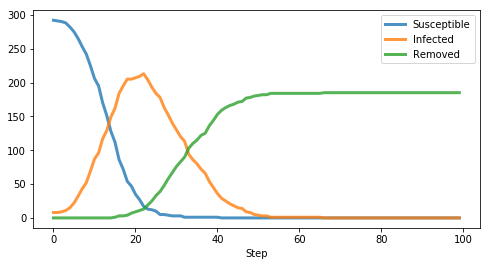

In [8]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SIR.png',dpi=150)

## Bokeh plots

In [100]:
def grid_values(model):
    """Get grid states"""
    
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    w=model.grid.width
    df=pd.DataFrame(agent_counts)
    for cell in model.grid.coord_iter():
        agents, x, y = cell
        c=None
        for a in agents:
            c = a.state
        df.iloc[x,y] = c
    return df

x=grid_values(model)

In [107]:
def plot_cells_bokeh(model):
    
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    w=model.grid.width
    df=grid_values(model) 
    df = pd.DataFrame(df.stack(), columns=['value']).reset_index()    
    columns = ['value']
    x = [(i, "@%s" %i) for i in columns]
    tools = 'box_select,box_zoom,lasso_select,pan,reset'    
    #hover = HoverTool(
    #    tooltips=x, point_policy='follow_mouse')
    colors = Category10[3]
    mapper = LinearColorMapper(palette=colors, low=df.value.min(), high=df.value.max())
    p = figure(plot_width=500,plot_height=500, tools=tools, x_range=(-1,w), y_range=(-1,w)) # tools = hover
    p.rect(x="level_0", y="level_1", width=1, height=1,
       source=df,
       fill_color={'field':'value', 'transform': mapper},
       line_color='black')
    p.background_fill_color = "black"
    p.grid.grid_line_color = None    
    p.axis.axis_line_color = None
    p.toolbar.logo = None
    return p

p=plot_cells_bokeh(model)
pn.pane.Bokeh(p)


Bokeh(Figure)

In [112]:

def plot_cells_bokeh(model):
    
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    w=model.grid.width
    df=grid_values(model) 
    df = pd.DataFrame(df.stack(), columns=['value']).reset_index()    
    columns = ['value']
    x = [(i, "@%s" %i) for i in columns]    
    hover = HoverTool(
        tooltips=x, point_policy='follow_mouse')
    colors = Category10[3]
    mapper = LinearColorMapper(palette=colors, low=df.value.min(), high=df.value.max())
    p = figure(plot_width=500,plot_height=500, tools=[hover], x_range=(-1,w), y_range=(-1,w))
    p.rect(x="level_0", y="level_1", width=1, height=1,
       source=df,
       fill_color={'field':'value', 'transform': mapper},
       line_color='black')
    p.background_fill_color = "white"
    p.grid.grid_line_color = None    
    p.axis.axis_line_color = None
    p.toolbar.logo = None
    return p

p=plot_cells_bokeh(model)
pn.pane.Bokeh(p)

Bokeh(Figure)

In [113]:
def plot_states_bokeh(model,title=''):
    """Plot cases per country"""
        
    X = get_column_data(model)
    X = X.reset_index()
    source = ColumnDataSource(X)
    i=0
    colors = Category10[3]
    items=[]
    p = figure(plot_width=600,plot_height=400,tools=[],title=title,x_range=(0,100))        
    for c in X.columns[1:]:
        line = Line(x='Step',y=c, line_color=colors[i],line_width=3,line_alpha=.8,name=c)
        glyph = p.add_glyph(source, line)
        i+=1
        items.append((c,[glyph]))

    p.xaxis.axis_label = 'Step'
    p.add_layout(Legend(location='center_right',   
                items=items))
    p.background_fill_color = "#e1e1ea"
    p.background_fill_alpha = 0.5
    p.legend.label_text_font_size = "10pt"
    p.title.text_font_size = "15pt"
    p.toolbar.logo = None
    p.sizing_mode = 'scale_height'    
    return p

p = plot_states_bokeh(model)
#pn.pane.Bokeh(p)

In [175]:
plot_pane = pn.pane.Bokeh()
grid_pane = pn.pane.Bokeh()
#pn.Row(plot_pane,grid_pane,sizing_mode='stretch_width')

In [177]:
# Determine where the visualization will be rendered
output_file('fchart.html')  # Render to static HTML, or 
output_notebook()  # Render inline in a Jupyter Notebook

# Set up the figure(s)
pn.Row(plot_pane,grid_pane,sizing_mode='stretch_width')
#fig = figure()  # Instantiate a figure() object

# Connect to and draw the data

# Organize the layout

# Preview and save 
#show(fig)  # See what I made, and save if I like it
#pn.pane.Bokeh(p)

Loading BokehJS ...

Row(sizing_mode='stretch_width')
    [0] Bokeh(None)
    [1] Bokeh(None)

### Experiment of saving animated chart as gif

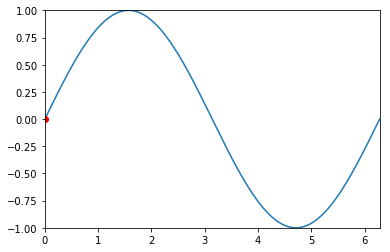

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rcParams

# make sure the full paths for ImageMagick and ffmpeg are configured
rcParams['animation.convert_path'] = r'C:\Program Files\ImageMagick\convert'
rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'

TWOPI = 2*np.pi

fig, ax = plt.subplots()

t = np.arange(0.0, TWOPI, 0.001)
s = np.sin(t)
l = plt.plot(t, s)

ax = plt.axis([0,TWOPI,-1,1])

redDot, = plt.plot([0], [np.sin(0)], 'ro')

def animate(i):
    redDot.set_data(i, np.sin(i))
    return redDot,

# create animation using the animate() function with no repeat
myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(0.0, TWOPI, 0.1), \
                                      interval=10, blit=True, repeat=False)

# save animation at 30 frames per second 
#myAnimation.save('myAnimation.gif', writer='imagemagick', fps=30)

In [164]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, curdoc
from datetime import datetime
from bokeh.io import export_png
import random

source = ColumnDataSource(dict(time = [datetime.now()], value = [random.randint(5, 10)]))
plot = figure(plot_width = 1200, x_axis_type = 'datetime', tools = 'pan,box_select,crosshair,reset,save,wheel_zoom')
plot.line(x = 'time', y = 'value', line_color = 'black', source = source)

counter = 0
def update():
    global counter
    new_source_data = dict(time = [datetime.now()], value = [random.randint(5, 10)])
    source.stream(new_source_data)
    counter = counter + 1
    export_png(plot, filename = "plot_" + str(counter) + ".png")

curdoc().add_root(plot)
curdoc().add_periodic_callback(update, 1000)

In [173]:
"""Bokeh Visualization Template

This template is a general outline for turning your data into a 
visualization using Bokeh.
"""
# Data handling
import pandas as pd
import numpy as np

# Bokeh libraries
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel

# Prepare the data

# Determine where the visualization will be rendered
output_file('filename.html')  # Render to static HTML, or 
output_notebook()  # Render inline in a Jupyter Notebook

# Set up the figure(s)
fig = figure()  # Instantiate a figure() object

# Connect to and draw the data

# Organize the layout

# Preview and save 
show(fig)  # See what I made, and save if I like it


Loading BokehJS ...

## Run the model with plot updates

In [155]:
steps=100
pop=400
st=time.time()
model = InfectionModel(pop, 20, 20, ptrans=0.25, death_rate=0.01)
for i in range(steps):
    model.step()    
    p1=plot_states_bokeh(model,title='step=%s' %i)
    plot_pane.object = p1
    p2=plot_cells_bokeh(model)
    grid_pane.object = p2
    time.sleep(0.2)
print (time.time()-st)

39.1309871673584


## Explore parameters 

In [14]:
def compute_max_infections(model):
    X=get_column_data(model)
    try:
        return X.Infected.max()
    except:
        return 0

compute_max_infections(model) 

232

In [15]:
from mesa.batchrunner import BatchRunner
fixed_params = {
    "width": 20,
    "height": 20,
    "N": 300,
}
#variable_params = {"N": range(20, 200, 10)}
variable_params = {"ptrans": np.arange(.05, .9, .1)}
batch_run = BatchRunner(
    InfectionModel,
    variable_params,
    fixed_params,
    iterations=3,
    max_steps=100,
    model_reporters={"Inf": compute_max_infections}
)

batch_run.run_all()

27it [00:22,  1.22it/s]


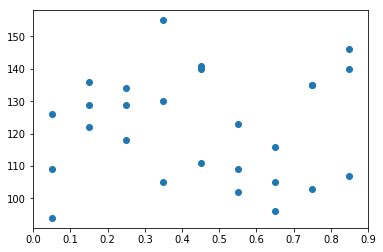

In [16]:
run_data = batch_run.get_model_vars_dataframe()
#run_data#.head()
plt.scatter(run_data.ptrans, run_data.Inf)